In [7]:
import numpy as np
import os
from google.colab import drive
import pickle
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Creating Environment

In [8]:

class GridWorld:
    def __init__(self, height, width, start, end, bad_region_clusters, good_region_clusters, final_reward, sparsity):
        self.height = height
        self.width = width
        self.start = start
        self.end = end
        self.bad_region_clusters = bad_region_clusters
        self.good_region_clusters = good_region_clusters
        # self.good_region_reward = good_region_reward
        # self.bad_region_reward = bad_region_reward
        self.final_reward = final_reward
        self.sparsity = sparsity

        self.state_rewards = self.generate_state_rewards()
        self.reset()

    def reset(self):
        self.agent_position = self.start


    def generate_state_rewards(self):
        state_rewards = {}
        for x in range(self.width):
            for y in range(self.height):
                state_reward = 0.0

                if (x, y) == self.start:
                    state_reward = 0.0
                elif (x, y) == self.end:
                    state_reward = self.final_reward
                else:
                    for cluster in self.good_region_clusters:
                        for point, reward in cluster:
                            if (x, y) == point:
                                state_reward += reward

                    for cluster in self.bad_region_clusters:
                        for point, reward in cluster:
                            if (x, y) == point:
                                state_reward += reward

                    if state_reward == 0.0:
                        state_reward = 0.5 if np.random.random() < self.sparsity else 0.0

                state_rewards[(x, y)] = state_reward

        return state_rewards


    def step(self, action):
        x, y = self.agent_position

        # Get the reward based on the current state and policy context
        reward = self.state_rewards.get((x, y), 0)

        if action == "up" and y < self.height - 1:
            y += 1
        elif action == "down" and y > 0:
            y -= 1
        elif action == "left" and x > 0:
            x -= 1
        elif action == "right" and x < self.width - 1:
            x += 1

        # Update agent position
        self.agent_position = (x, y)

        # Get the reward based on the current state and policy context
        reward = self.state_rewards.get(self.agent_position, 0)


        if self.agent_position in self.end:
            done = True
        else:
            done = False

        # Get the reward for the updated position and policy context
        updated_reward = self.state_rewards.get(self.agent_position, 0)

        # Check if the new position is the end state
        done = (self.agent_position == self.end)

        return self.agent_position, updated_reward, done



In [9]:
# # Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
# bad_cluster_2 = [((1, 0), -0.5), ((1, 1), -0.5)]
# good_cluster = []

# # Create an instance of GridWorld
# gridworld = GridWorld(
#     height=5,
#     width=5,
#     start=(0, 0),
#     end=(4, 4),
#     bad_region_clusters=[bad_cluster_1, bad_cluster_2],
#     good_region_clusters=[good_cluster],
#     final_reward=10,
#     sparsity=0.0
# )

# # Access the state_rewards dictionary
# rewards = gridworld.state_rewards

# # Print the rewards for each state
# for state, reward in rewards.items():
#     print(f"State: {state}, Reward: {reward}")

In [10]:
import numpy as np

class Agent:
    def __init__(self, epsilon=0.2):
        self.epsilon = epsilon

    def select_action(self, policy_func):
        if np.random.uniform() < self.epsilon:
            # Choose a random action
            action = np.random.choice(["up", "down", "left", "right"])
        else:
            # Use the provided policy function to get the best action
            action = policy_func()
        return action

# Define different policy functions outside the class

def random_policy():
    # Choose a random action
    return np.random.choice(["up", "down", "left", "right"])

# def behavior_policy(behav_policy):
#     action_probs = behav_policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

# def evaluation_policy(eval_policy):
#     action_probs = eval_policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

# def run_policy(policy):
#     action_probs = policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

def run_policy(agent_position, quadrant_policy_map):
    action_probs = get_quadrant_policy(agent_position, quadrant_policy_map)
    return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))


def manhattan_distance(pos1, pos2):
    # Compute the Manhattan distance between two positions
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])


In [11]:
height = 5
width = 5

# Define the quadrants of the gridworld based on midpoint
mid_x = width // 2
mid_y = height // 2

# # Define probability distributions for each quadrant
# behav_quadrant_probs = {
#     "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
#     "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
#     "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
#     "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
# }

# # Define probability distributions for each quadrant
# eval_quadrant_probs = {
#     "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
#     "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
#     "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
#     "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
# }


# Define a function to select the policy based on quadrant
def get_quadrant_policy(position, policy_map):
    x, y = position
    if x < mid_x:
        if y < mid_y:
            return policy_map["bottom_left"]
        else:
            return policy_map["top_left"]
    else:
        if y < mid_y:
            return policy_map["bottom_right"]
        else:
            return policy_map["top_right"]

# Update behav_policy and eval_policy with quadrant-based distributions
# behav_policy = get_quadrant_policy(agent_position, behav_quadrant_probs)
# eval_policy = get_quadrant_policy(agent_position, eval_quadrant_probs)


In [12]:
# get_quadrant_policy((1,2),behav_quadrant_probs)

# Generating Policy data

In [13]:
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

In [14]:
# def create_policy_set(env, policy_func, policy, num_episodes):
#   # Create a list to store policies as trajectories
#   policies = []

#   # Run multiple episodes
#   for episode in range(num_episodes):
#       # Create a new Agent for each episode to generate a different policy

#       agent = Agent(epsilon=0.0)

#       # print(episode)
#       # Run an episode
#       env.reset()
#       done = False
#       trajectory = []  # Store the trajectory for the current episode
#       cumulative_reward = 0.0  # Initialize cumulative reward
#       while not done:
#           state = env.agent_position  # Get the current state
#           # print("State: ",state)
#           action = agent.select_action(lambda: policy_func(policy))
#           # print("Action: ",action)
#           next_state, reward, done = env.step(action)
#           # print("Next State: ", next_state)

#           # Compute cumulative reward
#           cumulative_reward += reward


#           # good_region_distances = []
#           # if env.good_region_clusters:
#           #     good_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) for cluster in env.good_region_clusters]

#           # bad_region_distances = []
#           # if env.bad_region_clusters:
#           #     bad_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) for cluster in env.bad_region_clusters]

#           dist_to_terminal = manhattan_distance(state,env.end)

#           # Store the (state, action, reward, next_state) tuple in the trajectory
#           trajectory.append((state, action, reward, next_state, cumulative_reward, dist_to_terminal))

#       # Append the trajectory to the policies list
#       policies.append(trajectory)

#   return policies


In [15]:
def create_policy_set(env, policy_func, policy_map, num_episodes):
    # Create a list to store policies as trajectories
    policies = []

    # eval_policy_map, behav_policy_map = policy_maps  # Extract evaluation and behavior policy maps

    # Run multiple episodes
    for episode in range(num_episodes):
        # Create a new Agent for each episode to generate a different policy
        agent = Agent(epsilon=0.0)

        # Run an episode
        env.reset()
        done = False
        trajectory = []  # Store the trajectory for the current episode
        cumulative_reward = 0.0  # Initialize cumulative reward
        while not done:
            state = env.agent_position  # Get the current state
            action = agent.select_action(lambda: policy_func(state, policy_map))
            next_state, reward, done = env.step(action)
            dist_to_terminal = [manhattan_distance(state, env.end)]
            good_region_distances = []
            if env.good_region_clusters:
                good_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) for cluster in env.good_region_clusters]

            bad_region_distances = []
            if env.bad_region_clusters:
                bad_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) for cluster in env.bad_region_clusters]
            # Compute cumulative reward
            cumulative_reward += reward

            # Store the (state, action, reward, next_state) tuple in the trajectory
            trajectory.append((state, action, reward, next_state, cumulative_reward, dist_to_terminal,good_region_distances, bad_region_distances))

        # Append the trajectory to the policies list
        policies.append(trajectory)

    return policies


In [16]:
# pi_b = create_policy_set(gridworld, run_policy, behav_policy, 200)

In [17]:
def calc_V_pi_e(evaluation_policies):
    all_timesteps = []
    gamma = 0.9
    for j in range(len(evaluation_policies)):
        Timestep_values = []
        for i in range(len(evaluation_policies[j])):
          # print(i)
          timestep = gamma ** (i) * evaluation_policies[j][i][2]
          Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_est = sum([sum(sublist) for sublist in all_timesteps])/len(evaluation_policies)
    return V_est

# Saving and Loading Data

In [18]:
def filename(env, behav_policy, eval_policy, num_episodes, train_split, sparsity):
    good_clusters_str = "_".join([f"gc_{cluster_string(cluster)}" for cluster in env.good_region_clusters])
    bad_clusters_str = "_".join([f"bc_{cluster_string(cluster)}" for cluster in env.bad_region_clusters])

    # behav_probs_str = "_".join([f"{prob:.2f}" for prob in behav_policy.values()])
    # eval_probs_str = "_".join([f"{prob:.2f}" for prob in eval_policy.values()])

    file = f"{good_clusters_str}_{bad_clusters_str}_trajectories_{num_episodes}_train_split_{train_split}_sparsity_{sparsity}.txt"
    return file

def cluster_string(cluster):
    return "_".join([f"point_{pos[0]}_{pos[1]}_{reward:.2f}" for pos, reward in cluster])


In [19]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:

# Define the path to your desired folder
folder_path = '/content/drive/MyDrive/gridworld_ope_distance_to_reg_terminal_complex'

# Change the working directory to the specified folder
os.chdir(folder_path)


In [21]:

def save_data_to_file(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

def load_data_from_file(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data


# OPE Calculations

## Importance Weights

In [22]:
# def calculate_importance_weights(eval_policy, behav_policy, behavior_policies):
#   all_weights = []
#   for trajectory in behavior_policies:
#     cum_ratio = 1
#     cumul_weights = []
#     for step in trajectory:
#         ratio = eval_policy[step[1]]/behav_policy[step[1]]
#         # print("Ratio:",ratio)
#         cum_ratio *= ratio
#         cumul_weights.append(cum_ratio)
#         # print("Cumul:",cum_ratio)
#     all_weights.append(cumul_weights)

#   return all_weights

In [23]:
def calculate_importance_weights(eval_policy, behav_policy, behavior_policies):
    all_weights = []
    for trajectory in behavior_policies:
        cum_ratio = 1
        cumul_weights = []
        for step in trajectory:
            eval_action_probs = get_quadrant_policy(step[0], eval_policy)
            behav_action_probs = get_quadrant_policy(step[0], behav_policy)
            ratio = (0.8*eval_action_probs[step[1]] +0.2*0.25)/ (0.8*behav_action_probs[step[1]]+0.2*0.25)
            cum_ratio *= ratio
            cumul_weights.append(cum_ratio)
        all_weights.append(cumul_weights)

    return all_weights


## IS

In [24]:

def per_step_IS1(scope_set, num_bootstraps, eval_policy, behav_policy):
    all_timesteps = []
    gamma = 0.9
    # scope_set,_ = subset_policies(scope_set, phi_trajectories)
    scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_set)
    for j in range(len(scope_weights)):
        Timestep_values = []
        for i in range(len(scope_weights[j]) - 1):
            timestep = gamma ** (i) * scope_weights[j][i] * scope_set[j][i][2]
            Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_per_traj = [sum(sublist) for sublist in all_timesteps]


    num_trajectories_to_sample = max(1, len(V_per_traj))


    V_per_traj = [sum(sublist) for sublist in all_timesteps]
    num_trajectories_to_sample = max(1, len(V_per_traj))

    std_devs = []
    means = []

    seed_value = 0
    np.random.seed(seed_value)

    for i in range(5):

      bootstrap_samples = [np.random.choice(V_per_traj, size=num_trajectories_to_sample, replace=True)
                            for _ in range(num_bootstraps)]

      V_per_sample = [sum(sample)/len(scope_set) for sample in bootstrap_samples]
      V_per_sample = np.array(V_per_sample)

      std_deviation = np.std(V_per_sample)
      quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
      max_value = np.max(V_per_sample)
      min_value = np.min(V_per_sample)
      mean = np.mean(V_per_sample)

      std_devs.append(std_deviation)
      means.append(mean)

    return {
        'std_devs_list': std_devs,
        'mean_list': means
    }



## SCOPE

In [25]:

def SCOPE1(scope_policies, beta, num_bootstraps, eval_policy, behav_policy):
    all_timesteps = []
    gamma = 0.9
    scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_policies)
    for j in range(len(scope_weights)):
        Timestep_values = []
        for i in range(len(scope_weights[j]) - 1):
            features = scope_policies[j][i][5] + scope_policies[j][i][6] + scope_policies[j][i][7]
            features_next = scope_policies[j][i + 1][5] + scope_policies[j][i+1][6] + scope_policies[j][i+1][7]
            timestep = gamma ** (i) * scope_weights[j][i] * (scope_policies[j][i][2] + gamma * phi(features_next, beta) - phi(features, beta))
            Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    features_0 = scope_policies[0][0][5]+ scope_policies[j][0][6] + scope_policies[j][0][7]
    shaped = phi(features_0,beta)

    V_per_traj = [sum(sublist) for sublist in all_timesteps]
    num_trajectories_to_sample = max(1, len(V_per_traj))

    V_per_traj_shaped = [x - shaped for x in V_per_traj]


    std_devs = []
    means = []
    seed_value = 0
    np.random.seed(seed_value)
    for i in range(5):

      bootstrap_samples = [np.random.choice(V_per_traj_shaped, size=num_trajectories_to_sample, replace=True)
                            for _ in range(num_bootstraps)]

      V_per_sample = [sum(sample)/len(scope_policies) for sample in bootstrap_samples]
      V_per_sample = np.array(V_per_sample)

      std_deviation = np.std(V_per_sample)
      quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
      max_value = np.max(V_per_sample)
      min_value = np.min(V_per_sample)
      mean = np.mean(V_per_sample)

      std_devs.append(std_deviation)
      means.append(mean)

    return {
        'std_devs_list': std_devs,
        'mean_list': means
    }


In [26]:
# V_per_traj_shaped = SCOPE1(scope_set, 0.5, 100)
# bootstrap_samples = [np.random.choice(V_per_traj_shaped, size=len(V_per_traj_shaped), replace=True) for _ in range(100)]

# Variance Preparation and Calculation

## Phi functions

In [27]:
def phi(features, beta):
  features = np.array(features)
  beta = np.array(beta)
  phi_linear = np.dot(beta,features)
  return phi_linear


In [28]:
def phi2(features, beta):
    features = np.array(features)
    beta = np.array(beta)

    # Calculate the matrix multiplication and then element-wise multiplication
    phi_quadratic = np.dot(features, np.dot(beta, features.T))

    return phi_quadratic

## Subset Policies

In [29]:

def subset_policies(policies, percent_to_estimate_phi):
    # seed_value = 0
    # np.random.seed(seed_value)
    num_policies = len(policies)
    num_policies_to_estimate_phi = int(num_policies * percent_to_estimate_phi)

    policies_for_scope = policies[num_policies_to_estimate_phi:]
    policies_for_phi = policies[:num_policies_to_estimate_phi]

    return policies_for_scope, policies_for_phi


## Variance Terms

In [30]:
import random
# gamma = 0.9
# beta = [random.random() for _ in range(3)]
def variance_terms(policy_set,gamma, beta, eval_policy, behav_policy):
  all_weights = calculate_importance_weights(eval_policy, behav_policy, policy_set)
  y_w_r_all = 0
  r_all = 0
  f_a = 0
  for n in range(len(policy_set)):
    y_w_r = 0
    r = 0
    for t in range(len(policy_set[n])-1):
      features = policy_set[n][t][5]+ policy_set[n][t][6] + policy_set[n][t][7]
      y_w_r += gamma**(t)*all_weights[n][t]*policy_set[n][t][2]
      if t>0:
        r += phi(features, beta)*(all_weights[n][t-1]-all_weights[n][t])
    features_last = policy_set[n][-1][5]+ policy_set[n][-1][6] + policy_set[n][-1][7]
    features_first = policy_set[n][0][5]+ policy_set[n][0][6] + policy_set[n][0][7]
    y_w_r_all += y_w_r
    f_a +=  gamma**(len(policy_set[n]))*all_weights[n][-1]*phi(features_last,beta) - phi(features_first, beta)
    r_all += r

  IS = y_w_r_all/len(policy_set)
  R = r_all/len(policy_set)
  F = f_a/len(policy_set)
  return IS, R, F


In [31]:
def calc_variance(phi_policies, gamma, beta, num_bootstrap_samples, eval_policy, behav_policy):
  # Set the seed value (you can use any integer value)
  seed_value = 0
  np.random.seed(seed_value)
  num_trajectories_to_sample = max(1, len(phi_policies))

  bootstrap_samples = [np.random.choice(phi_policies, size=num_trajectories_to_sample, replace=True)
                         for _ in range(num_bootstrap_samples)]
  IS_all = []
  R_all = []
  F_all = []

  for pol in bootstrap_samples:
    IS, R, F = variance_terms(pol,0.9,beta, eval_policy, behav_policy)
    IS_all.append(IS)
    R_all.append(R)
    F_all.append(F)
  IS_sq = np.mean([num**2 for num in IS_all])
  IS_R_F = 2*np.mean([IS_all[i]*(R_all[i]+F_all[i]) for i in range(len(IS_all))])
  R_sq = np.mean([num**2 for num in R_all])
  IS_sq_all = (np.mean(IS_all))**2
  IS_r_t_f = 2*np.mean(IS_all)*np.mean([R_all[i]+F_all[i] for i in range(len(R_all))])
  R_sq_all = (np.mean(R_all))**2

  variance_scope = IS_sq + IS_R_F + R_sq - IS_sq_all - IS_r_t_f - R_sq_all
  variance_is = IS_sq - IS_sq_all
  return variance_scope, variance_is

# Optimization

Here we aim to optimize beta to minimize SCOPE variance.

In [32]:
# Define the objective function to minimize variance_scope
def objective_function(beta, phi_set, eval_policy, behav_policy):
    # scope_set, phi_set = subset_policies(phi_set, phi_trajectories)
    variance_scope, variance_is = calc_variance(phi_set, 0.9, beta, 100, eval_policy, behav_policy)
    return variance_scope

# Set the initial values of beta
# initial_beta = np.array([ 0.2610704,   0.30396575, -0.43850237])


def optimize_variance_scope(initial_beta, phi_set, phi_trajectories, eval_policy, behav_policy):
    # Lists to store beta and variance_scope values at each iteration
    all_betas = []
    all_variance_scopes = []

    # Callback function to record beta and variance_scope values at each iteration
    def callback_function(beta):
        all_betas.append(beta.copy())
        variance_scope = objective_function(beta, phi_set,eval_policy, behav_policy)
        all_variance_scopes.append(variance_scope)
        print("Iteration:", len(all_betas))
        print("Beta:", beta)
        print("Variance Scope:", variance_scope)
        print("----------")

    # Run the optimization with the callback
    result = minimize(
        objective_function,
        initial_beta,
        args=(phi_set, eval_policy, behav_policy),
        method='L-BFGS-B',
        callback=callback_function
    )

    # Extract the optimal beta values
    optimal_beta = result.x

    return optimal_beta


# Optimization with bounds

In [ ]:
# from scipy.optimize import minimize

# # Define the bounds for each beta
# def bounds_generator(env):
#     bounds = []
#     num_good_clusters = len(env.good_region_clusters)
#     num_bad_clusters = len(env.bad_region_clusters)

#     for _ in range(num_good_clusters):
#         bounds.append((None, 0))  # Negative or zero for good clusters

#     for _ in range(num_bad_clusters):
#         bounds.append((0, None))  # Positive or zero for bad clusters

#     return bounds


# # Define the objective function to minimize variance_scope
# def objective_function(beta, phi_set):
#     # scope_set, phi_set = subset_policies(phi_set, phi_trajectories)
#     variance_scope, variance_is = calc_variance(phi_set, 0.9, beta, 100)
#     return variance_scope

# # Set the initial values of beta
# # initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(env.good_region_clusters) + len(env.bad_region_clusters))]

# def optimize_variance_scope(initial_beta, phi_set, phi_trajectories, env):
#     # Lists to store beta and variance_scope values at each iteration
#     all_betas = []
#     all_variance_scopes = []

#     # Callback function to record beta and variance_scope values at each iteration
#     def callback_function(beta):
#         all_betas.append(beta.copy())
#         variance_scope = objective_function(beta, phi_set)
#         all_variance_scopes.append(variance_scope)
#         print("Iteration:", len(all_betas))
#         print("Beta:", beta)
#         print("Variance Scope:", variance_scope)
#         print("----------")

#     # Generate bounds based on the environment
#     bounds = bounds_generator(env)

#     # Run the optimization with the callback
#     result = minimize(
#         objective_function,
#         initial_beta,
#         args=(phi_set),
#         method='L-BFGS-B',
#         bounds=bounds,
#         callback=callback_function
#     )

#     # Extract the optimal beta values
#     optimal_beta = result.x

#     return optimal_beta


In [ ]:
# bounds_generator(gridworld)

# Playground to run individual trajectories

In [ ]:
# height = 5
# width = 5

# # Define the quadrants of the gridworld based on midpoint
# mid_x = width // 2
# mid_y = height // 2

# # Define probability distributions for each quadrant
# behav_policy = {
#     "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
#     "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
#     "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
#     "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
# }

# # Define probability distributions for each quadrant
# eval_policy = {
#     "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
#     "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
#     "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
#     "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
# }

In [ ]:
# np.random.seed(42)
# # Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
# good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]
# # good_cluster = [((4, 2), 1), ((4, 3), 0)]

# # Create an instance of GridWorld
# gridworld = GridWorld(
#     height=5,
#     width=5,
#     start=(0, 0),
#     end=(4, 4),
#     bad_region_clusters=[bad_cluster_1],
#     good_region_clusters=[good_cluster_1],
#     final_reward=10,
#     sparsity=0.0
# )

# # Access the state_rewards dictionary
# rewards = gridworld.state_rewards

# # Print the rewards for each state
# for state, reward in rewards.items():
#     print(f"State: {state}, Reward: {reward}")

# behavior_policies = create_policy_set(gridworld, run_policy,behav_policy, 200)


In [ ]:
# env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.1)
# # behavior_policies = create_policy_set(gridworld, run_policy,behav_policy, 200)
# initial_beta = random.uniform(-0.5, 0.5)
# scope_set, phi_set = subset_policies(behavior_policies, 0.3)
# # # bounds = bounds_generator(gridworld)

# optimal_beta = optimize_variance_scope(initial_beta, phi_set, 0.3,eval_policy, behav_policy)
# variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500,eval_policy, behav_policy)
# print("Var SCOPE_phi: ",variance_scope)
# print("Var IS_phi: ",variance_is)
# print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

In [ ]:
# scope_results = SCOPE1(scope_set,optimal_beta[0],500,eval_policy, behav_policy)
# IS_results = per_step_IS1(scope_set,500,eval_policy, behav_policy)
# print("SCOPE results: ", scope_results)
# print("IS results: ", IS_results)
# evaluation_policies = create_policy_set(gridworld, run_policy,eval_policy, 1000)
# true_evaluation = calc_V_pi_e(evaluation_policies)
# print("true eval: ", true_evaluation)

SCOPE results:  {'std_devs_list': [0.03476238842086804, 0.03612893393226335, 0.037243016705316864, 0.03661220014993137, 0.03589215961058758], 'mean_list': [-0.23451534632435858, -0.23125870683627994, -0.2307036955537556, -0.23191238233728836, -0.23543771695906207]}
IS results:  {'std_devs_list': [0.03734599686145158, 0.038654305936218034, 0.039705540276610614, 0.03935767323324145, 0.038777787865288495], 'mean_list': [-0.24212126937335995, -0.2383185714743656, -0.23777173536002608, -0.23905092725400845, -0.24261344633209625]}
true eval:  1.8539803529445233


# Modify Data

In [ ]:
# def modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
#   file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
#   # Check if the file already exists
#   if os.path.exists(file):
#     loaded_data = load_data_from_file(file)
#     behavior_policies = loaded_data['policy_set']
#     scope_set, phi_set = subset_policies(behavior_policies, phi_traj)
#     beta = loaded_data['optimal_beta']
#     # scope_results = loaded_data['scope_results']
#     scope_results_new = SCOPE1(scope_set,beta,500)
#     IS_results_new = per_step_IS1(scope_set,500)
#     loaded_data['scope_results'] = scope_results_new
#     loaded_data['IS_results'] = IS_results_new
#     true_evals = []
#     for i in range(5):
#       evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
#       true_evaluation = calc_V_pi_e(evaluation_policies)
#       true_evals.append(true_evaluation)
#     loaded_data['True Evaluations'] = true_evals
#     save_data_to_file(loaded_data, file)
#     print("modifying... ")
#     print("scope new: ",scope_results_new)
#     print("IS new: ", IS_results_new)



# Experiment Function

In [33]:
def run_experiment1(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
  file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
  # Check if the file already exists
  if os.path.exists(file):
    loaded_data = load_data_from_file(file)
    # loaded_data = modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity)
    return loaded_data

  behavior_policies = create_policy_set(env, run_policy,behav_policy, num_episodes)
  # initial_beta = random.uniform(-0.5, 0.5)
  initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(env.good_region_clusters) + len(env.bad_region_clusters)+1)]
  scope_set, phi_set = subset_policies(behavior_policies, phi_traj)
  optimal_beta = optimize_variance_scope(initial_beta, phi_set, phi_traj,eval_policy, behav_policy)
  variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500, eval_policy, behav_policy)
  print("Var SCOPE_phi: ",variance_scope)
  print("Var IS_phi: ",variance_is)
  print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)
  scope_results = SCOPE1(scope_set,optimal_beta,500,eval_policy, behav_policy)
  IS_results = per_step_IS1(scope_set,500,eval_policy, behav_policy)
  print("SCOPE results: ", scope_results)
  print("IS results: ", IS_results)
  true_evals = []
  for i in range(5):
    evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
    true_evaluation = calc_V_pi_e(evaluation_policies)
    true_evals.append(true_evaluation)
  print("true eval: ", np.mean(np.array(true_evals)))
  data_to_save = {
    'policy_set': behavior_policies,
    'optimal_beta': optimal_beta,
    'variance_scope_train': variance_scope,
    'variance_IS_train': variance_is,
    'scope_results': scope_results,
    'IS_results': IS_results,
    'True Evaluations': true_evals
  }
  save_data_to_file(data_to_save, file)

  return data_to_save



In [34]:
def run_loaded(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
  file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
  # Check if the file already exists
  if os.path.exists(file):
    loaded_data = load_data_from_file(file)
    # loaded_data = modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity)
    return loaded_data

# Plotting Functions

In [36]:
def plot_rewards_over_trajectories1(env, num_trajectories, behav_policy, eval_policy, phi_traj, sparsity):
    # combined_scope = []
    # combined_is = []

    combined_scope_means = []
    combined_scope_std_devs = []
    combined_is_means = []
    combined_is_std_devs = []

    combined_scope_vars = []
    combined_scope_var_std_devs = []
    combined_is_vars = []
    combined_is_var_std_devs = []

    combined_scope_bias = []
    combined_scope_bias_std_devs = []
    combined_is_bias = []
    combined_is_bias_std_devs = []

    combined_scope_mse = []
    combined_is_mse = []


    for i in range(len(num_trajectories)):
        results = run_loaded(env, num_trajectories[i], behav_policy, eval_policy, phi_traj, sparsity)
        print("Trajectories: ", num_trajectories[i])
        # if num_trajectories[i] == 200:
        true_val = results['True Evaluations']
        print("True Val: ",true_val)

        optimal_beta = results['optimal_beta']
        print("Optimal Beta: ", optimal_beta)

        true_value = np.mean(np.array(true_val))
        scope_results = results['scope_results']
        is_results = results['IS_results']

        print('SCOPE Results: ', scope_results)
        print('IS Results: ', is_results)

        sd_scope = scope_results['std_devs_list']
        sd_is = is_results['std_devs_list']

        means_scope = scope_results['mean_list']
        means_is = is_results['mean_list']

        combined_scope_means.append(np.mean(np.array(means_scope)))
        combined_scope_std_devs.append(np.std(np.array(means_scope)))
        combined_is_means.append(np.mean(np.array(means_is)))
        combined_is_std_devs.append(np.std(np.array(means_is)))

        combined_scope_vars.append(np.mean(np.array(sd_scope)**2))
        combined_scope_var_std_devs.append(np.std(np.array(sd_scope)**2))
        combined_is_vars.append(np.mean(np.array(sd_is)**2))
        combined_is_var_std_devs.append(np.std(np.array(sd_is)**2))


        combined_scope_bias.append(np.mean(np.array(means_scope)-np.array(true_val)))
        combined_scope_bias_std_devs.append(np.std(np.array(means_scope)-np.array(true_val)))
        combined_is_bias.append(np.mean(np.array(means_is)-np.array(true_val)))
        combined_is_bias_std_devs.append(np.std(np.array(means_is)-np.array(true_val)))

        mse_scope = np.mean(np.array(sd_scope)**2) + (np.mean(np.array(means_scope)-np.array(true_val)))**2
        # print("mse_scope: ", mse_scope)
        combined_scope_mse.append(mse_scope)
        combined_is_mse.append(np.mean(np.array(sd_is)**2) + (np.mean(np.array(means_is)-np.array(true_val)))**2)

    plt.figure()
    # Plotting
    plt.plot(num_trajectories, combined_scope_vars, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_vars, color='black', marker='o', label='stepIS')
    plt.errorbar(num_trajectories, combined_scope_vars, yerr=combined_scope_var_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_vars, yerr=combined_is_var_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Variance')
    plt.title('SCOPE and stepIS Variance Plots vs. Number of Trajectories')
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()




    plt.figure()

    plt.figure()
    # Plotting
    plt.plot(num_trajectories, combined_scope_bias, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_bias, color='black', marker='o', label='stepIS')
    plt.errorbar(num_trajectories, combined_scope_bias, yerr=combined_scope_bias_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_bias, yerr=combined_is_bias_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Bias')
    plt.title('SCOPE and stepIS Bias Plots vs. Number of Trajectories')
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()



    plt.figure()

    # Plotting
    plt.plot(num_trajectories, combined_scope_means, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_means, color='black', marker='o', label='stepIS')
    plt.errorbar(num_trajectories, combined_scope_means, yerr=combined_scope_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_means, yerr=combined_is_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Value Estimate')
    plt.title('SCOPE and stepIS Value Estimate Plots vs. Number of Trajectories')

    # Add horizontal line for true_val
    plt.axhline(y=true_value, color='green', linestyle='--', label='True Value')

    # Create custom legend handles and labels
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS'),
        Line2D([0], [0], color='green', linestyle='--', label='True Value')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()

    plt.figure()

    # Plotting
    plt.plot(num_trajectories, combined_scope_mse, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_mse, color='black', marker='o', label='stepIS')


    plt.xlabel('Number of Trajectories')
    plt.ylabel('MSE')
    plt.title('SCOPE and stepIS MSE Plots vs. Number of Trajectories')


    # Create custom legend handles and labels
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()




# Compare Trajectories

In [37]:
def compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, phi_traj, sparsity):
  for i in num_trajectories:
    print("Loading ",i, " trajectories: ")
    run_experiment1(env,i ,behav_policy, eval_policy, phi_traj, sparsity)

  plot_rewards_over_trajectories1(env,num_trajectories,behav_policy, eval_policy, phi_traj,sparsity)
  # plot_mse_over_trajectories(env,num_trajectories,behav_policy, eval_policy, phi_traj,sparsity)

In [38]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

## Dense 2 bad regions, 1 good, sparse environment

In [ ]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
bad_cluster_2 = [((1, 0), -1), ((1, 1), -1)]
good_cluster = [((4, 2), 1), ((4, 3), 1)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[good_cluster],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0)

## Sparse 2 bad, 1 good, sparse environment

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), -1), ((3, 3), 0)]
bad_cluster_2 = [((1, 0), 0), ((1, 1), -1)]
good_cluster = [((4, 2), 1), ((4, 3), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[good_cluster],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse 2 good, Dense 1 bad

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
good_cluster_1 = [((1, 2), 1), ((1, 1), 0)]
good_cluster_2 = [((4, 2), 1), ((4, 3), 0),((3, 2), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1, good_cluster_2],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Dense, 1 bad 1 good

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
good_cluster_1 = [((4, 2), 1), ((4, 3), 1)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0)

# Sparse, 1 bad, 1 good

In [40]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

# Define the quadrants of the gridworld based on midpoint
mid_x = width // 2
mid_y = height // 2

# Define probability distributions for each quadrant
behav_policy_quad = {
    "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
    "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
}

# Define probability distributions for each quadrant
eval_policy_quad = {
    "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
    "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
}

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.33537697 -0.30181641 -0.11225329]
Variance Scope: 0.18783252635141318
----------
Iteration: 2
Beta: [-0.02030143 -0.09152894  0.1205936 ]
Variance Scope: 0.02501764253592527
----------
Iteration: 3
Beta: [-0.02250354 -0.04582969  0.0857403 ]
Variance Scope: 0.024114076846349253
----------
Iteration: 4
Beta: [-0.06046484  0.07138618  0.03046554]
Variance Scope: 0.023182049575179876
----------
Iteration: 5
Beta: [-0.09011831  0.10276831  0.04215929]
Variance Scope: 0.02307006745185013
----------
Iteration: 6
Beta: [-0.11664591  0.12193982  0.06049997]
Variance Scope: 0.023034202958251346
----------
Iteration: 7
Beta: [-0.11663745  0.1220467   0.06024733]
Variance Scope: 0.02303419375024129
----------
Var SCOPE_phi:  0.02474800057185425
Var IS_phi:  0.026228741865589638
Percent change in variance:  -5.645491123148463
SCOPE results:  {'std_devs_list': [0.11834524564010122, 0.11861190262981378, 0.10637650126737656, 0.11431942311753135, 0.1

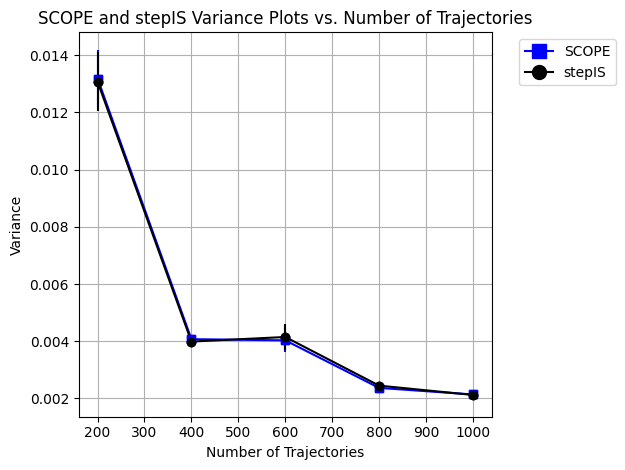

<Figure size 640x480 with 0 Axes>

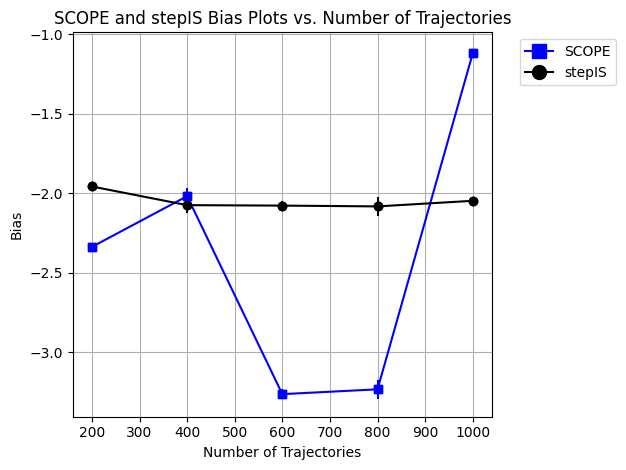

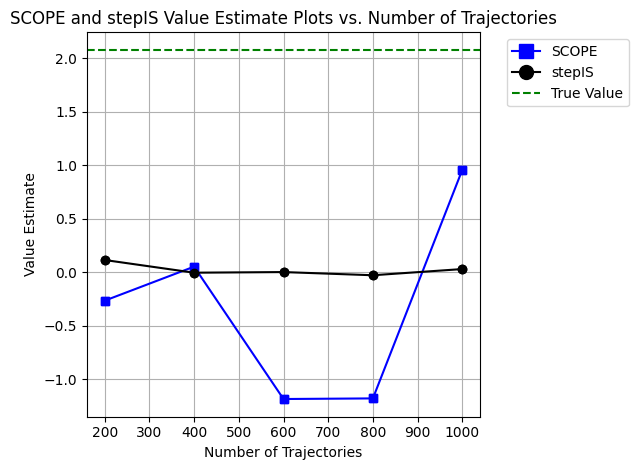

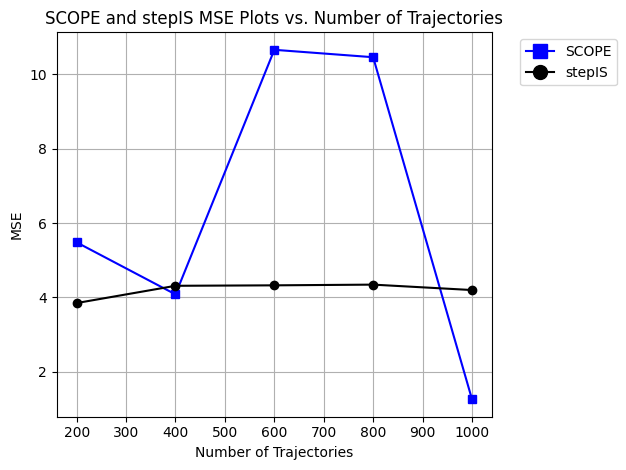

In [50]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), -1), ((3, 3), 0)]
good_cluster_1 = [((4, 2), 1), ((4, 3), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Iteration: 1
Beta: [ 0.02009054  0.14746209 -0.29204439]
Variance Scope: 0.020710652184627358
----------
Iteration: 2
Beta: [ 0.00316789  0.11328955 -0.21877577]
Variance Scope: 0.017925813338731257
----------
Iteration: 3
Beta: [-0.15787676  0.04476378  0.08737304]
Variance Scope: 0.013310699660866124
----------
Iteration: 4
Beta: [-0.09921236  0.00386036  0.07621184]
Variance Scope: 0.013223248244457583
----------
Iteration: 5
Beta: [-0.11940288  0.02477963  0.06962866]
Variance Scope: 0.013131206219458638
----------
Var SCOPE_phi:  0.013437848449753844
Var IS_phi:  0.01639990915999895
Percent change in variance:  -18.06144583696764
SCOPE results:  {'std_devs_list': [0.05440215693645237, 0.053217746440230106, 0.05236819055324853, 0.05148906216642067, 0.05538846632933587], 'mean_list': [0.7325065059517033, 0.7276454914093039, 0.7297692429358964, 0.7284408885774931, 0.7310540987575047]}
IS results:  {'std_devs_list': [0.05777231635697208, 0.0556392497618698

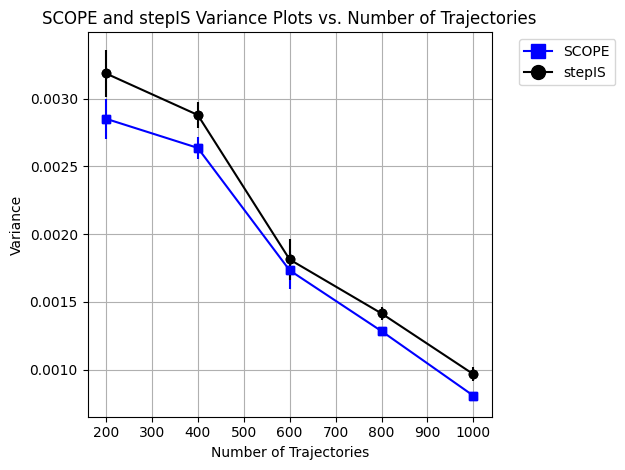

<Figure size 640x480 with 0 Axes>

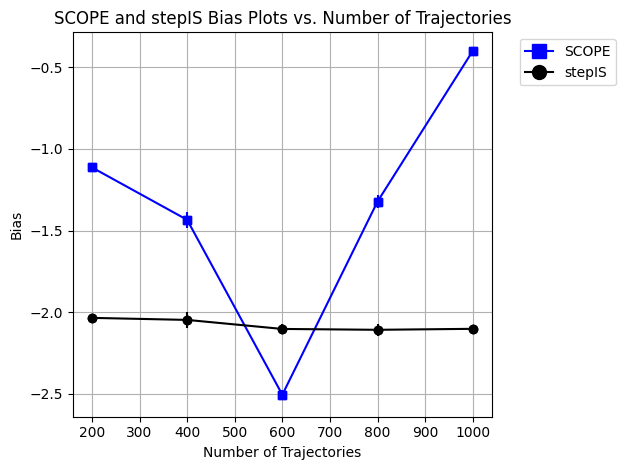

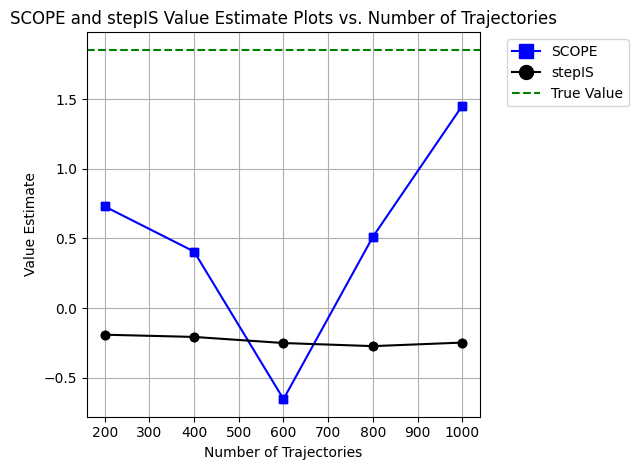

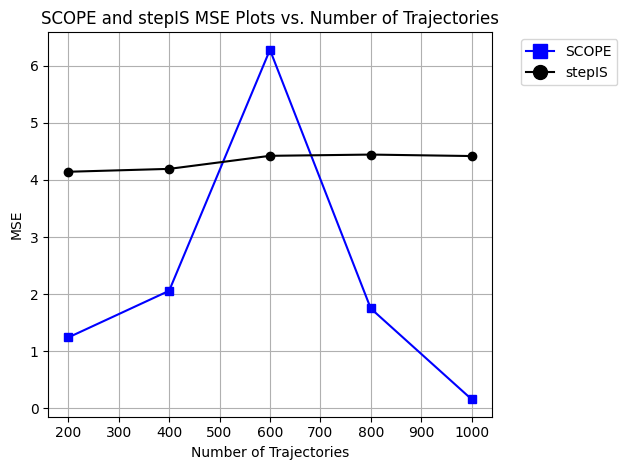

In [55]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), -1), ((3, 3), 0)]
good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.26938065  0.02749342  0.25525758]
Variance Scope: 0.004255300802288267
----------
Iteration: 2
Beta: [-0.23875954  0.02357898  0.22236655]
Variance Scope: 0.0034359108234610996
----------
Iteration: 3
Beta: [-0.1520236   0.05550638  0.06314556]
Variance Scope: 0.00211854941314602
----------
Iteration: 4
Beta: [-0.14218997  0.03625454  0.08021573]
Variance Scope: 0.002100901222748439
----------
Iteration: 5
Beta: [-0.14851605  0.04324328  0.07752071]
Variance Scope: 0.002090985566822353
----------
Var SCOPE_phi:  0.0023633384478415724
Var IS_phi:  0.005486385174909306
Percent change in variance:  -56.923577683722506
SCOPE results:  {'std_devs_list': [0.03577402311711307, 0.036976353546291967, 0.03601661013174326, 0.035328491150802034, 0.03605535849327925], 'mean_list': [0.9113972451133538, 0.906973703664459, 0.9069040811800624, 0.9106578557213566, 0.9064886107764478]}
IS results:  {'std_devs_list': [0.04326587070071175, 0.0448075128008

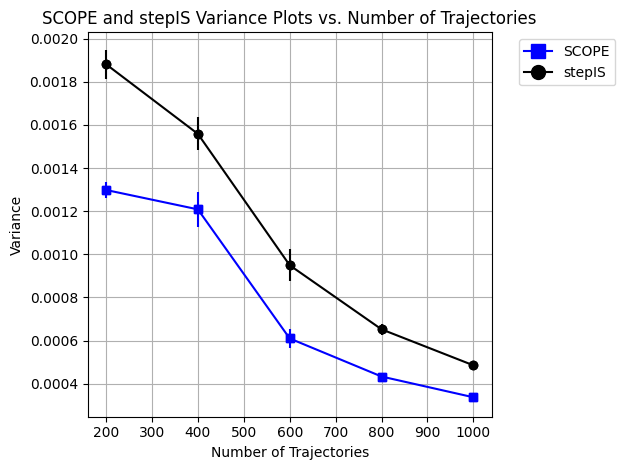

<Figure size 640x480 with 0 Axes>

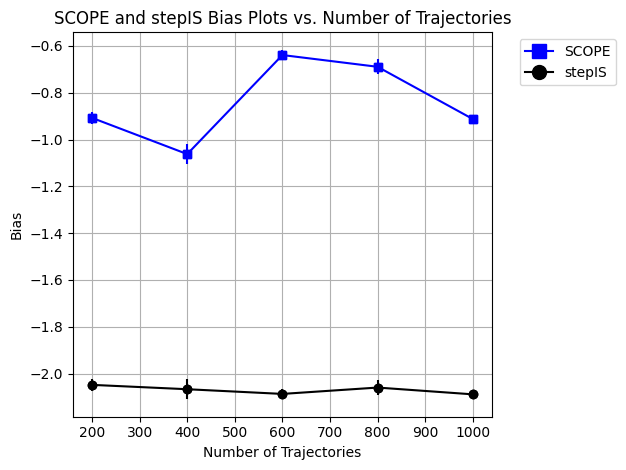

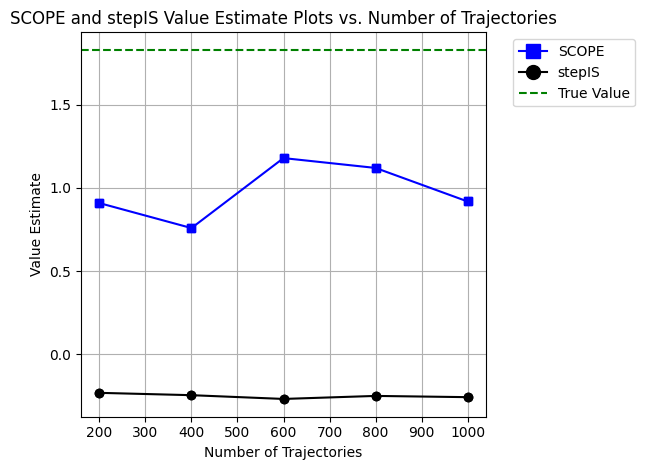

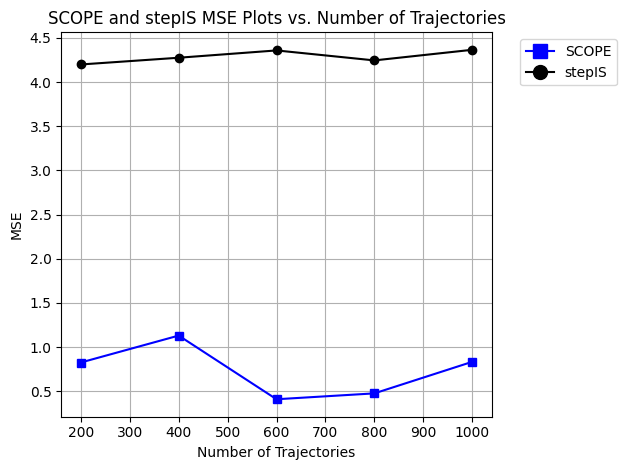

In [51]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Iteration: 1
Beta: [ 0.12619796 -0.21969941  0.12528349]
Variance Scope: 0.011476874071754902
----------
Iteration: 2
Beta: [ 0.03882417 -0.11752152  0.08520115]
Variance Scope: 0.0063705204834446656
----------
Iteration: 3
Beta: [-0.1702434   0.08675617  0.04302688]
Variance Scope: 0.002032643829973143
----------
Iteration: 4
Beta: [-0.18184885  0.08624848  0.05651698]
Variance Scope: 0.0020128291848299446
----------
Iteration: 5
Beta: [-0.1859296   0.08512051  0.06252909]
Variance Scope: 0.0020108921496331342
----------
Var SCOPE_phi:  0.0017841256950724572
Var IS_phi:  0.0033268000893829225
Percent change in variance:  -46.37111797711329
SCOPE results:  {'std_devs_list': [0.040124286348230925, 0.03876095420357538, 0.038506122480534186, 0.041265889090155654, 0.04146562406980251], 'mean_list': [1.3131136813488473, 1.3124911996600566, 1.313860342734838, 1.3168267265935818, 1.3141177310555991]}
IS results:  {'std_devs_list': [0.048030258934601534, 0.04832146

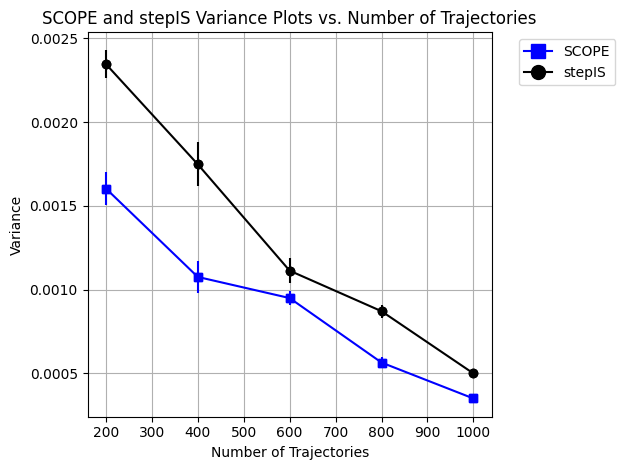

<Figure size 640x480 with 0 Axes>

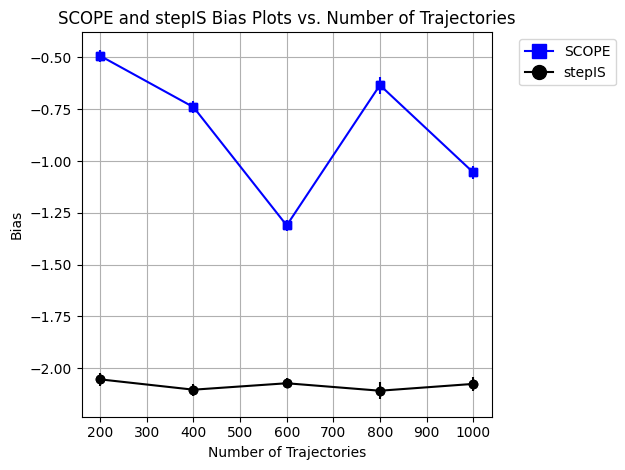

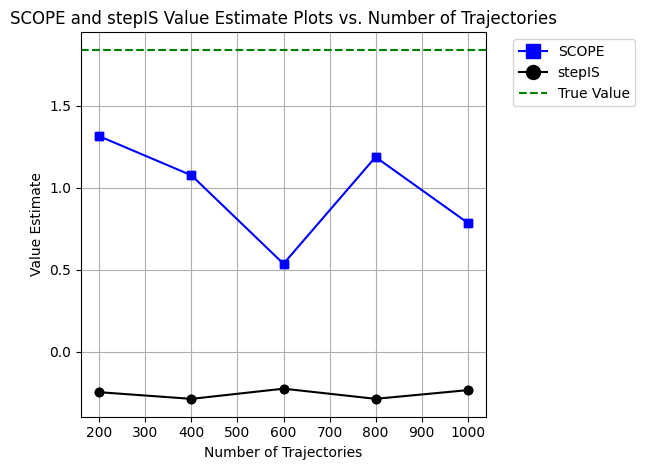

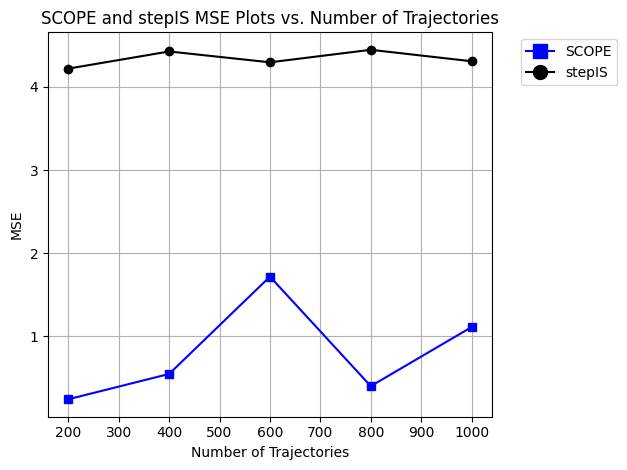

In [41]:
# np.random.seed(42)
# # Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
# good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


# env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
#     good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
# num_trajectories = [200,400, 600, 800,1000]
# compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.4, 0.0)

In [ ]:
# np.random.seed(42)
# # Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
# good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


# env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
#     good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
# num_trajectories = [200,400, 600, 800,1000]
# compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.35, 0.0)

In [ ]:
# np.random.seed(42)
# # Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
# good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


# env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
#     good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
# num_trajectories = [200,400, 600, 800,1000]
# compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.5, 0.001)

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.11544598  0.27844775 -0.0968856 ]
Variance Scope: 0.00999092021134841
----------
Iteration: 2
Beta: [-0.10626341  0.27267417 -0.10138968]
Variance Scope: 0.009774307943101256
----------
Iteration: 3
Beta: [-0.05884707  0.22172675 -0.10970872]
Variance Scope: 0.0091024675886149
----------
Iteration: 4
Beta: [-0.04313136  0.18384757 -0.09762684]
Variance Scope: 0.008868237142093135
----------
Iteration: 5
Beta: [-0.02286016  0.08910857 -0.04961248]
Variance Scope: 0.008517573123335962
----------
Iteration: 6
Beta: [-0.02489917  0.08327863 -0.04358515]
Variance Scope: 0.008510611119396248
----------
Iteration: 7
Beta: [-0.02514778  0.08346102 -0.04348163]
Variance Scope: 0.008510594834708186
----------
Var SCOPE_phi:  0.009437202020429072
Var IS_phi:  0.009551834703723228
Percent change in variance:  -1.2001116733047388
SCOPE results:  {'std_devs_list': [0.06281364521499214, 0.06565041081908353, 0.0664655758992407, 0.06220882647793952, 0

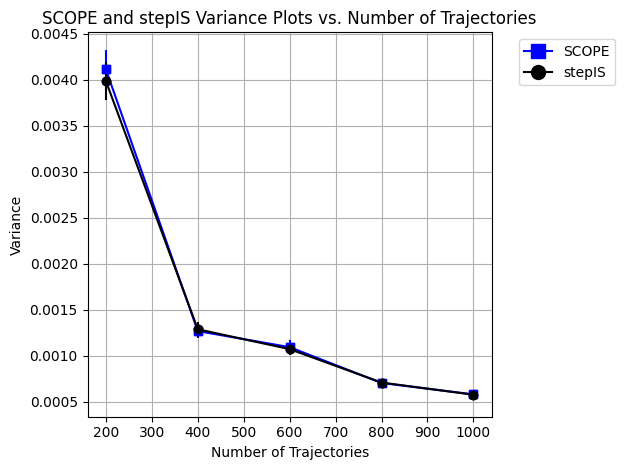

<Figure size 640x480 with 0 Axes>

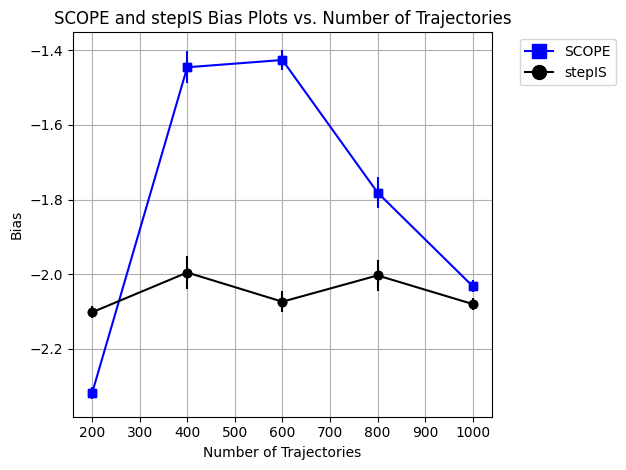

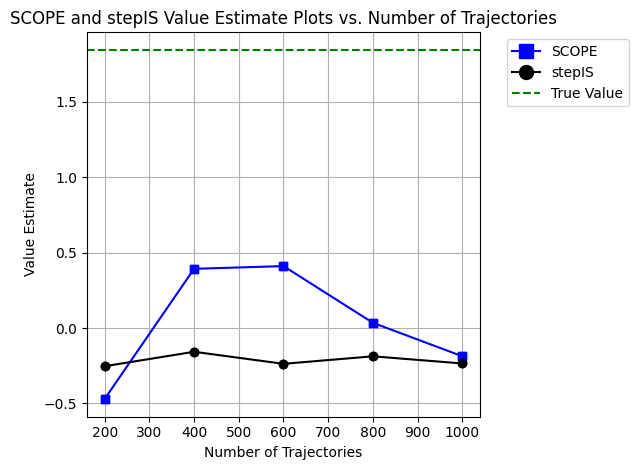

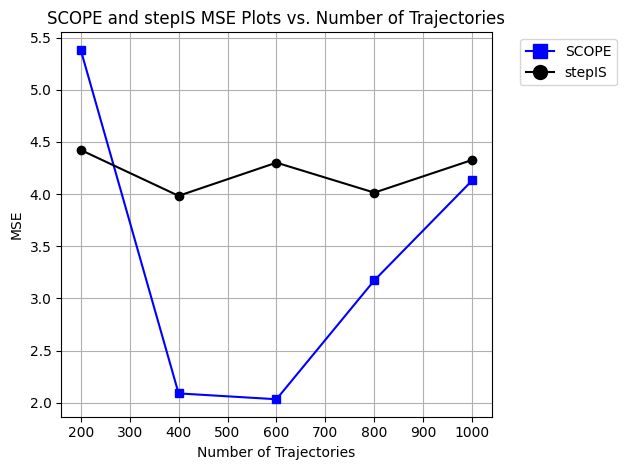

In [52]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 1), 0), ((2, 2), -1)]
good_cluster_1 = [((3, 2), 1), ((4, 2), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Iteration: 1
Beta: [ 0.19742298 -0.04527721 -0.17366677]
Variance Scope: 0.01796277113139151
----------
Iteration: 2
Beta: [ 0.16344456 -0.03941683 -0.14347324]
Variance Scope: 0.015023353144398633
----------
Iteration: 3
Beta: [ 0.02162155 -0.00603152 -0.02396753]
Variance Scope: 0.009626767142161687
----------
Iteration: 4
Beta: [ 0.0069169   0.0384548  -0.04154547]
Variance Scope: 0.009499116121842312
----------
Iteration: 5
Beta: [-0.01663701  0.1264944  -0.08196122]
Variance Scope: 0.009394789641926082
----------
Iteration: 6
Beta: [-0.01657175  0.12656469 -0.08207879]
Variance Scope: 0.009394787273934736
----------
Var SCOPE_phi:  0.010329495939938961
Var IS_phi:  0.010706016093411957
Percent change in variance:  -3.5169025544870185
SCOPE results:  {'std_devs_list': [0.06777718341990623, 0.0710796922565149, 0.0721029307019867, 0.06601260628813933, 0.06770340307111052], 'mean_list': [-0.7872330104805999, -0.7903542788168535, -0.7887183491467421, -0.785

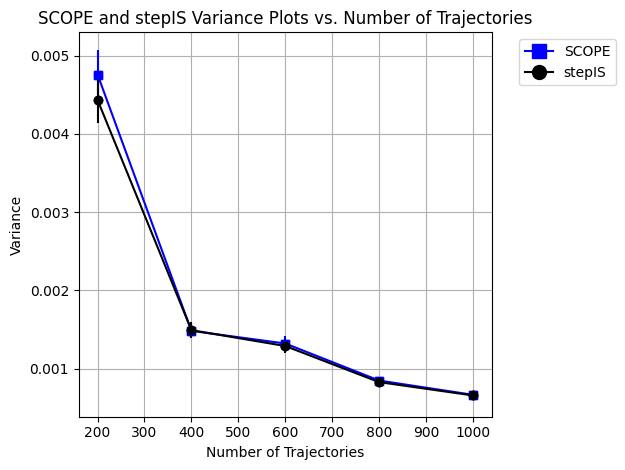

<Figure size 640x480 with 0 Axes>

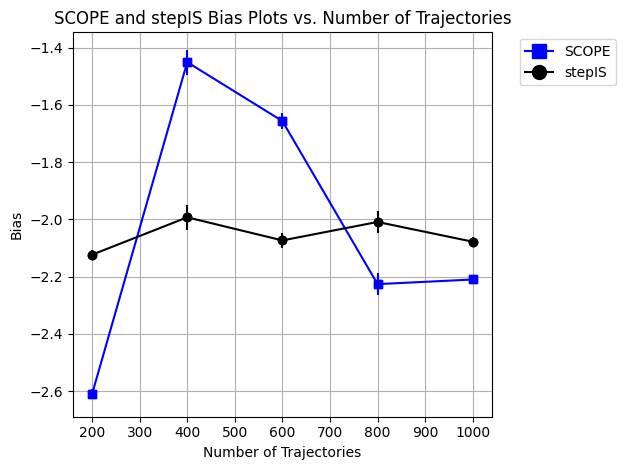

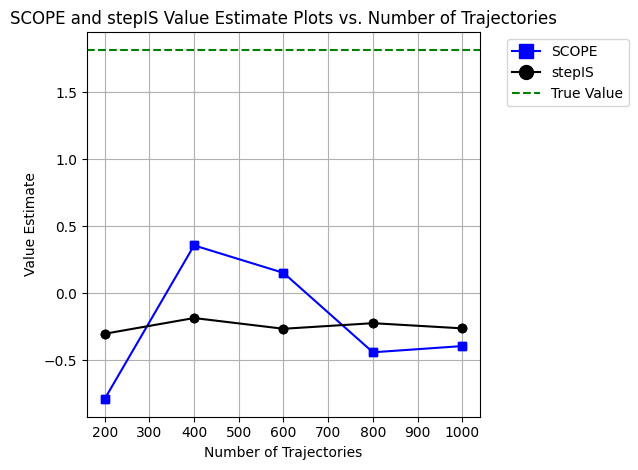

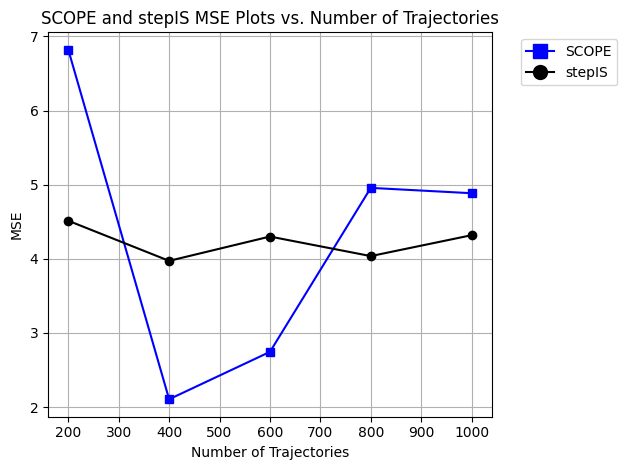

In [53]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 1), -0.2), ((2, 2), -1), ((2,3),0)]
good_cluster_1 = [((3, 2), 1), ((3, 3), 0.2)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.00899005  0.05915063 -0.03608931]
Variance Scope: 0.028659909314455355
----------
Iteration: 2
Beta: [ 0.00242326  0.04852817 -0.04141795]
Variance Scope: 0.028588033360503334
----------
Iteration: 3
Beta: [ 0.01703936  0.03074498 -0.04523354]
Variance Scope: 0.02855066476549699
----------
Iteration: 4
Beta: [ 0.01690207  0.03001199 -0.04454991]
Variance Scope: 0.02855058717446613
----------
Iteration: 5
Beta: [ 0.01685666  0.0299154  -0.04442877]
Variance Scope: 0.028550585586820276
----------
Var SCOPE_phi:  0.03207991989323143
Var IS_phi:  0.031368126256695494
Percent change in variance:  2.2691621128756636
SCOPE results:  {'std_devs_list': [0.0881431664346426, 0.08656544712139938, 0.0809161058305325, 0.08255187825218556, 0.08701663319715837], 'mean_list': [-0.03936661181655764, -0.0479008300874885, -0.04466323049771169, -0.0462053474391427, -0.045089531421476675]}
IS results:  {'std_devs_list': [0.08758112588248991, 0.086324157338

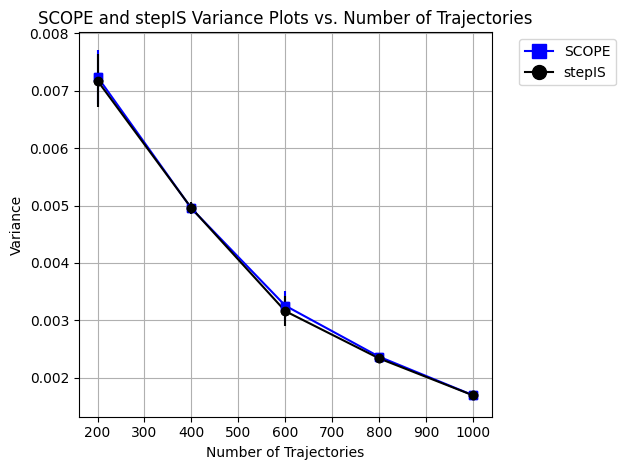

<Figure size 640x480 with 0 Axes>

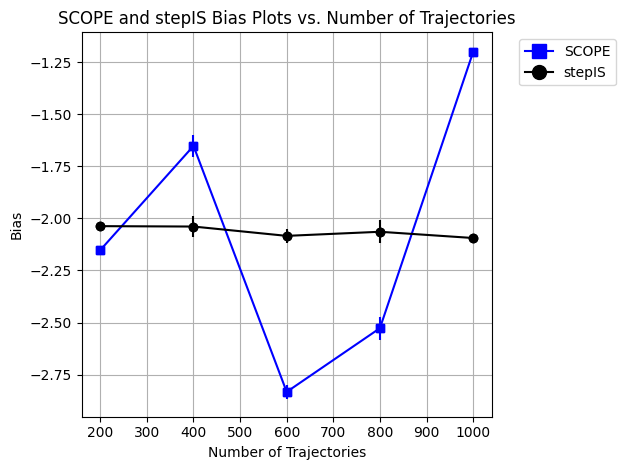

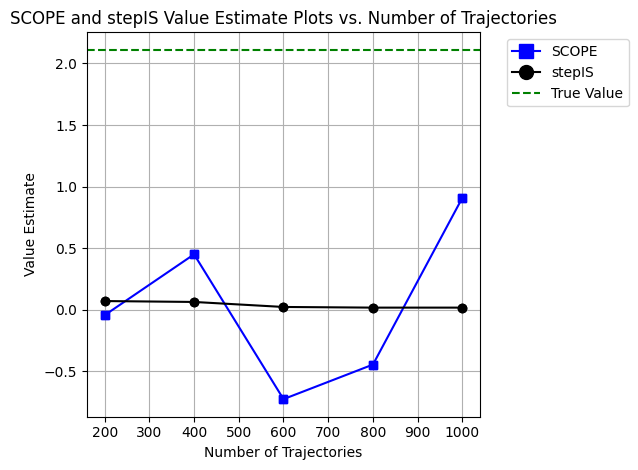

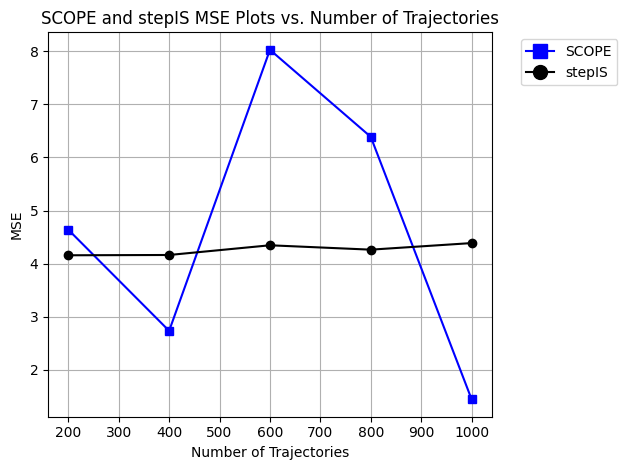

In [56]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -0.2), ((2, 4), -1)]
good_cluster_1 = [((3, 2), 1), ((4, 2), 0.2)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

## Sparse 1 bad, 1 good, larger

In [ ]:
np.random.seed(42)
# Gridworld environment
height = 10
width  = 10
start = (0,0)
end = (9,9)

# Define the quadrants of the gridworld based on midpoint
mid_x = width // 2
mid_y = height // 2

# Define probability distributions for each quadrant
behav_policy_quad = {
    "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
    "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
}

# Define probability distributions for each quadrant
eval_policy_quad = {
    "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
    "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
}

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.001)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.001)

## Dense 2 bad

## Dense 2 bad, 0.7 for training

## Sparse 2 bad, sparse environment

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
bad_cluster_2 = [((1, 0), 0), ((1, 1), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
# eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
# behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1),((3, 4), 0)]
bad_cluster_2 = [((1, 2), -1), ((1, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
# eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
# behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
#Seeds removed from SCOPE and IS

np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 2), 0), ((2, 3), -1), ((2, 4), 0)]
bad_cluster_2 = [((3, 1), -1), ((4, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse 3 bad

### Mid Sparsity

## Sparse 2 good

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), 1),((3, 4), 0)]
good_cluster_2 = [((1, 2), 1), ((1, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1, good_cluster_2],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 2), 0), ((2, 3), 0), ((2, 4), 1),((3, 4), 0)]
good_cluster_2 = [((1, 2), 1), ((1, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1, good_cluster_2],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse 1 good

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 2), 0), ((2, 3), 0), ((2, 4), 1),((3, 4), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse, 1 bad

In [61]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

# Define the quadrants of the gridworld based on midpoint
mid_x = width // 2
mid_y = height // 2

# Define probability distributions for each quadrant
behav_policy_quad = {
    "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
    "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
}

# Define probability distributions for each quadrant
eval_policy_quad = {
    "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
    "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
}

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.07515601  0.03414761]
Variance Scope: 0.016545228045771694
----------
Iteration: 2
Beta: [-0.07823014  0.03764437]
Variance Scope: 0.016516689137189046
----------
Iteration: 3
Beta: [-0.10374156  0.06666381]
Variance Scope: 0.016404999403404796
----------
Var SCOPE_phi:  0.01717235142283376
Var IS_phi:  0.020495859434324304
Percent change in variance:  -16.215509391739307
SCOPE results:  {'std_devs_list': [0.05664053325375149, 0.05584728960062403, 0.054594865243410465, 0.05325786519432703, 0.05763382752869264], 'mean_list': [0.6668222249083383, 0.6607577669528826, 0.66323295991587, 0.6624307183731133, 0.6641093928299843]}
IS results:  {'std_devs_list': [0.06129603013786814, 0.05966201881250443, 0.05945763495408167, 0.05712540510283273, 0.061804261798224354], 'mean_list': [-0.27356212353061893, -0.28106246660823675, -0.278337130597859, -0.2775613765770481, -0.2776004454846778]}
true eval:  1.7616700054883876
Loading  400  trajectories:

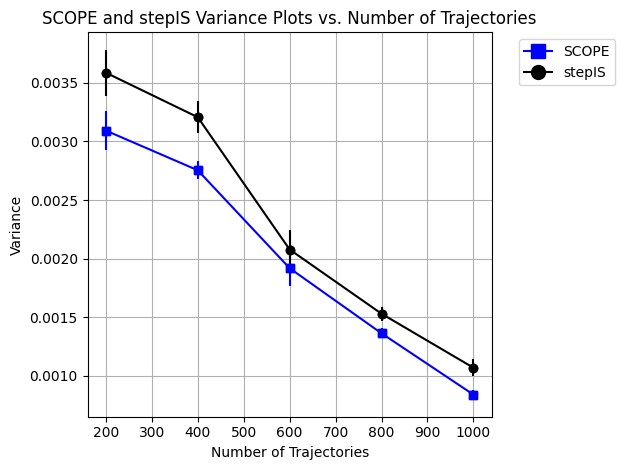

<Figure size 640x480 with 0 Axes>

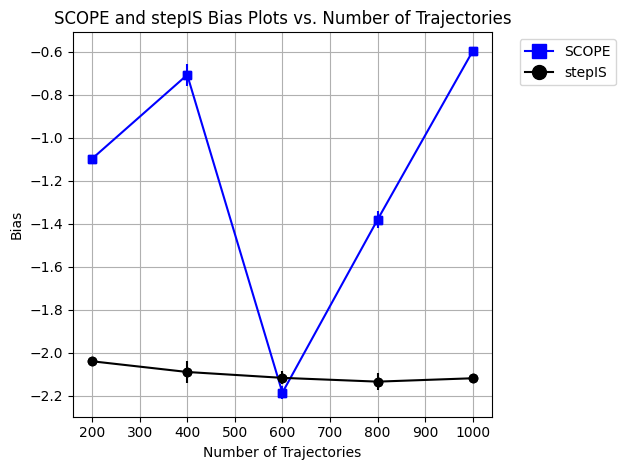

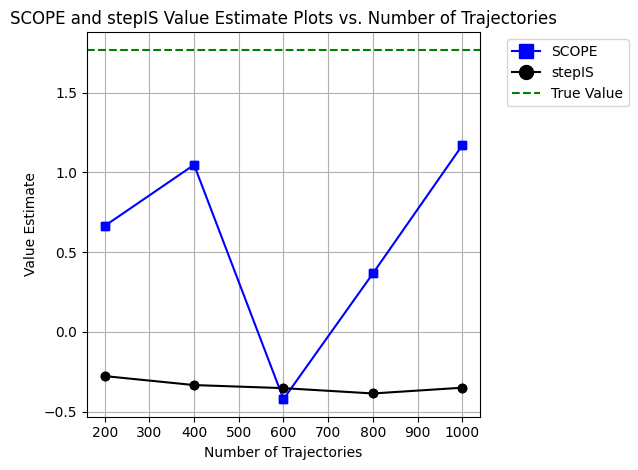

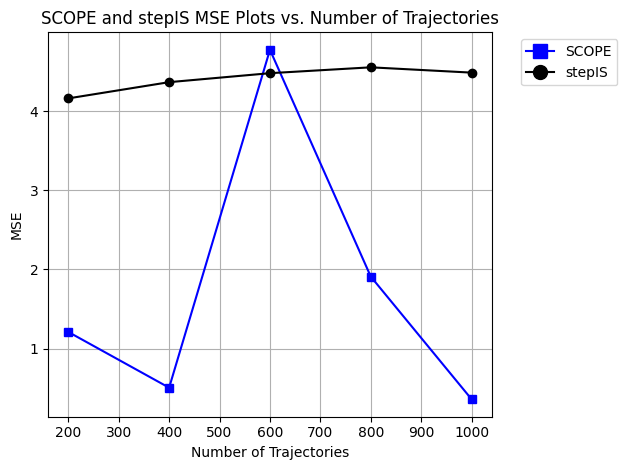

In [57]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -0.2), ((2, 4), -1)]
# good_cluster_1 = [((3, 2), 1), ((4, 2), 0.2)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.16848575  0.24267778]
Variance Scope: 0.004860592866970751
----------
Iteration: 2
Beta: [-0.16321097  0.23323966]
Variance Scope: 0.004831420262615155
----------
Iteration: 3
Beta: [-0.13142503  0.17636662]
Variance Scope: 0.004750258555979849
----------
Var SCOPE_phi:  0.004414411450381633
Var IS_phi:  0.006378800586768915
Percent change in variance:  -30.795587817275123
SCOPE results:  {'std_devs_list': [0.03862612283882148, 0.04076997693466068, 0.04088970433547748, 0.03864374241481959, 0.04051823247151319], 'mean_list': [-0.18954480057025105, -0.18940141693947554, -0.19384944233310014, -0.18875150237702115, -0.1923902646073222]}
IS results:  {'std_devs_list': [0.04441995517934967, 0.04723611660651575, 0.04699322193591984, 0.044465381175306413, 0.04623019061458447], 'mean_list': [-0.34037618432675415, -0.33953642854996086, -0.34534859211367896, -0.33924857705380307, -0.3438143911687654]}
true eval:  1.7903762807365589
Loading  400 

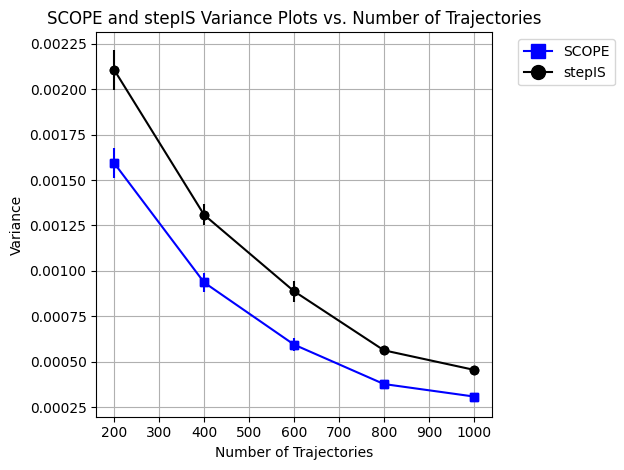

<Figure size 640x480 with 0 Axes>

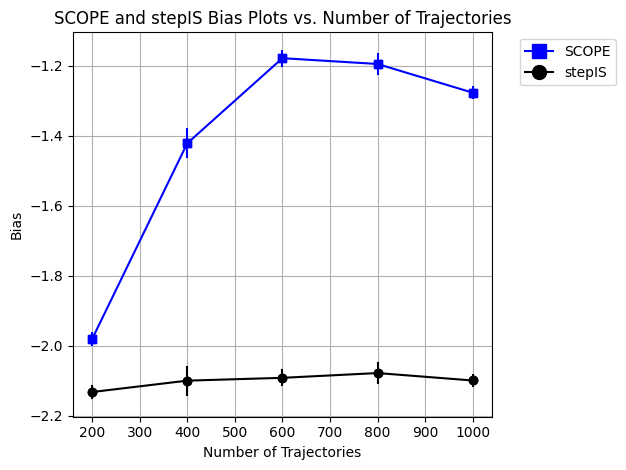

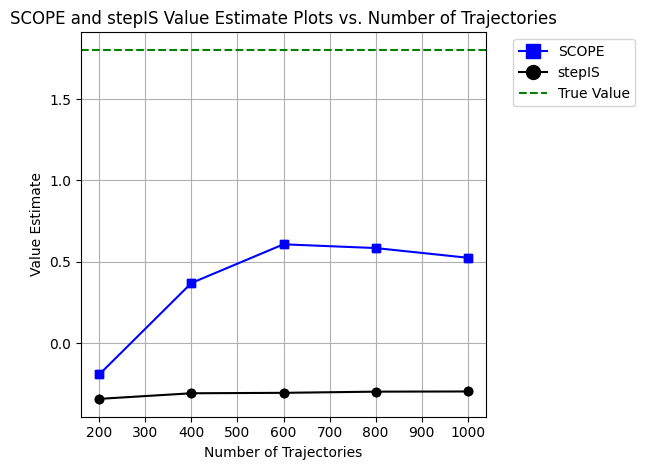

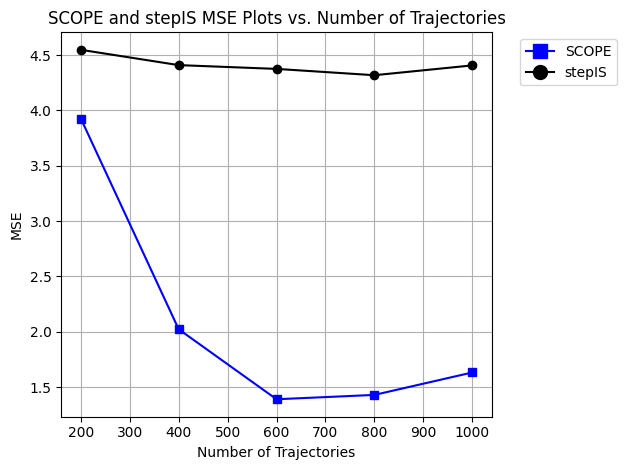

In [62]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.13824159  0.13576727]
Variance Scope: 0.005541913357015538
----------
Iteration: 2
Beta: [-0.14922466  0.15546401]
Variance Scope: 0.005415108282269733
----------
Iteration: 3
Beta: [-0.21534245  0.27403758]
Variance Scope: 0.005062696045359121
----------
Var SCOPE_phi:  0.005037318178060842
Var IS_phi:  0.01080765905475034
Percent change in variance:  -53.39121864834582
SCOPE results:  {'std_devs_list': [0.04480013040861419, 0.04521427876655567, 0.04757880946286307, 0.047759952489309525, 0.0467617431484722], 'mean_list': [0.04966107410535092, 0.04766031275418929, 0.047495725715066814, 0.04630714256388893, 0.052643513858732366]}
IS results:  {'std_devs_list': [0.050278528062949655, 0.051006784206530244, 0.05221922719434066, 0.05212922755798577, 0.051994978152785525], 'mean_list': [-0.3655129279819655, -0.36637886709588463, -0.36890188516784267, -0.36834050535664437, -0.36343362775149396]}
true eval:  1.771935559154245
Loading  400  tr

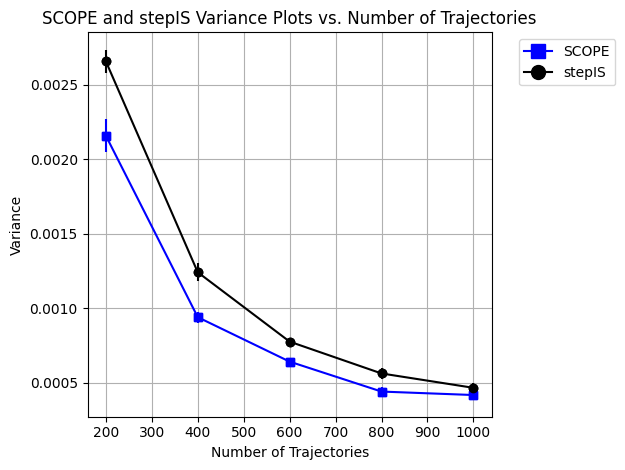

<Figure size 640x480 with 0 Axes>

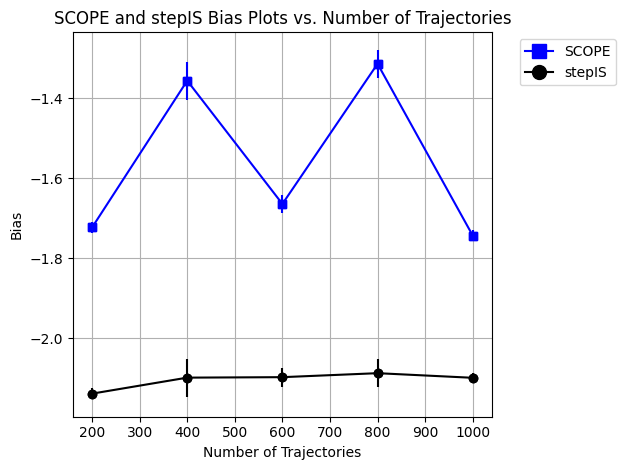

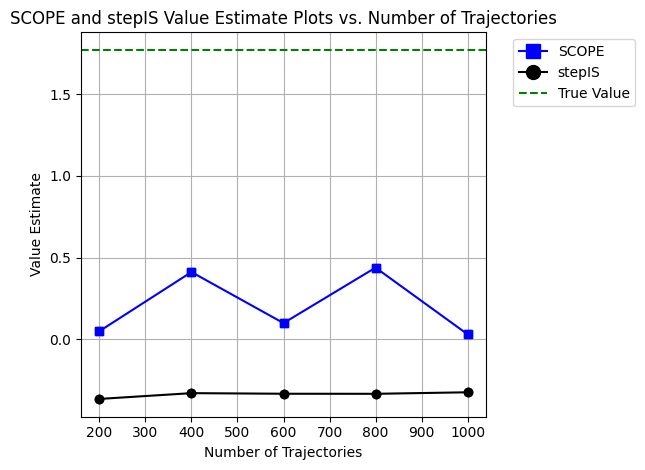

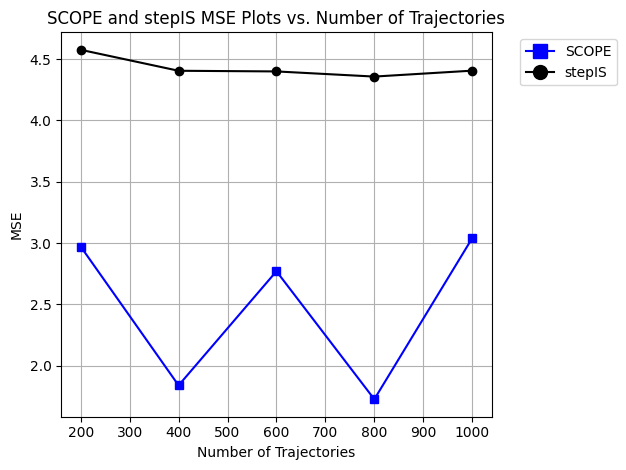

In [45]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), 0), ((3, 3), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.23265731  0.33072622]
Variance Scope: 0.002434509499327859
----------
Iteration: 2
Beta: [-0.22574951  0.3183407 ]
Variance Scope: 0.0023843548099080356
----------
Iteration: 3
Beta: [-0.18415435  0.24376323]
Variance Scope: 0.0022449322425281987
----------
Var SCOPE_phi:  0.002452924178399255
Var IS_phi:  0.006934320943127473
Percent change in variance:  -64.62632464639064
SCOPE results:  {'std_devs_list': [0.06381265355081633, 0.06058084719304081, 0.06070951039242118, 0.0602294032506715, 0.06214044288361188], 'mean_list': [-0.026607569291486607, -0.022560308110664, -0.020570788831308917, -0.024618115193585553, -0.02450691781804649]}
IS results:  {'std_devs_list': [0.06974437848617344, 0.06662984241023413, 0.0636644804773306, 0.06663251889972856, 0.06708408472076581], 'mean_list': [-0.2757817305675225, -0.2707600993040767, -0.27070977600851825, -0.2733286600224178, -0.27449631129281227]}
true eval:  1.8180239620769096
Loading  400  t

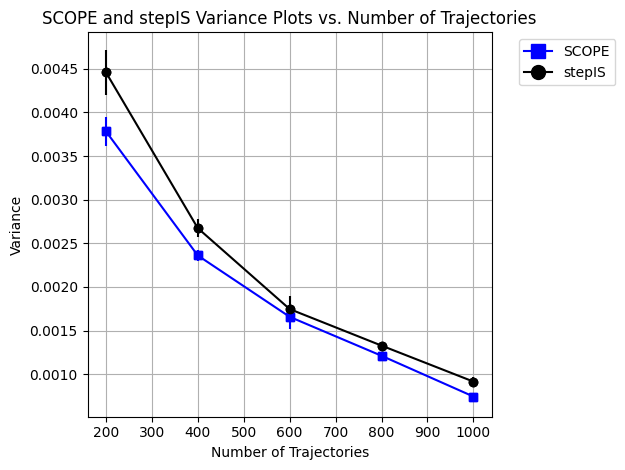

<Figure size 640x480 with 0 Axes>

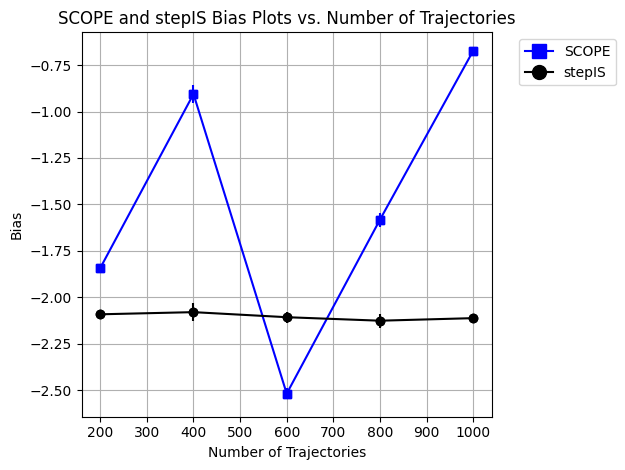

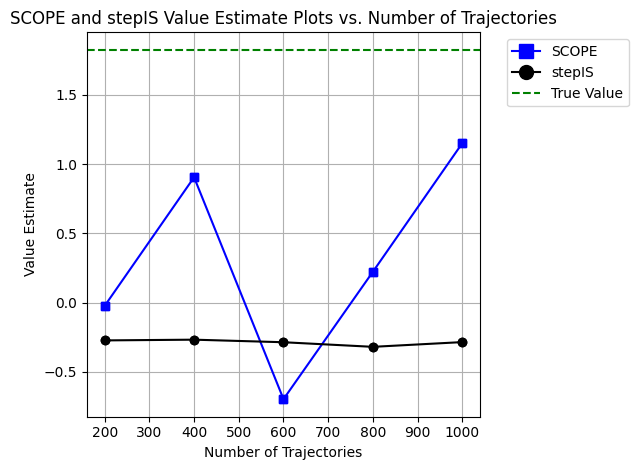

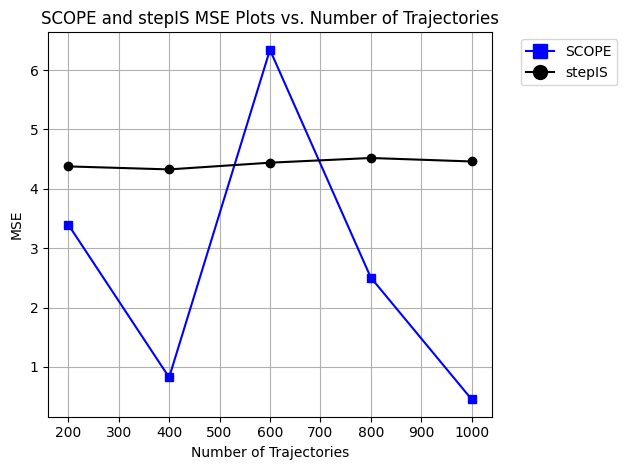

In [46]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), -1), ((3, 3), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Loading  2000  trajectories: 
Iteration: 1
Beta: [-0.28449382  0.3688221 ]
Variance Scope: 0.0015069851389892253
----------
Iteration: 2
Beta: [-0.24545467  0.30881934]
Variance Scope: 0.0011508307653540148
----------
Iteration: 3
Beta: [-0.10523249  0.09329206]
Variance Scope: 0.0005893568031531751
----------
Var SCOPE_phi:  0.0005718392684886438
Var IS_phi:  0.0008430158639324281
Percent change in variance:  -32.167436823646824
SCOPE results:  {'std_devs_list': [0.015313402150717425, 0.01514775631339837, 0.015809177281107412, 0.015594256717346487, 0.015477288580625604], 'mean_list': [0.5146280479871247, 0.5149491368912759, 0.5149879773905415, 0.5158325855551555, 0.5144669731637476]}
IS results:  {'std_devs_list': [0.0185389522865449, 0.01824786893828655, 0.019120725934776362, 0.018622617698608367, 0.018585694626863002], 'mean_list': [-0.538

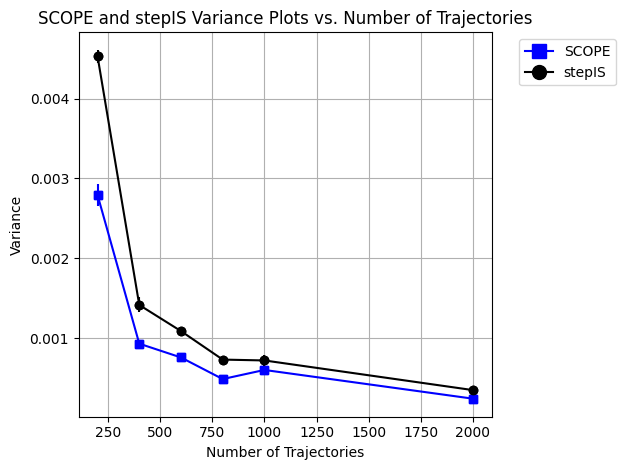

<Figure size 640x480 with 0 Axes>

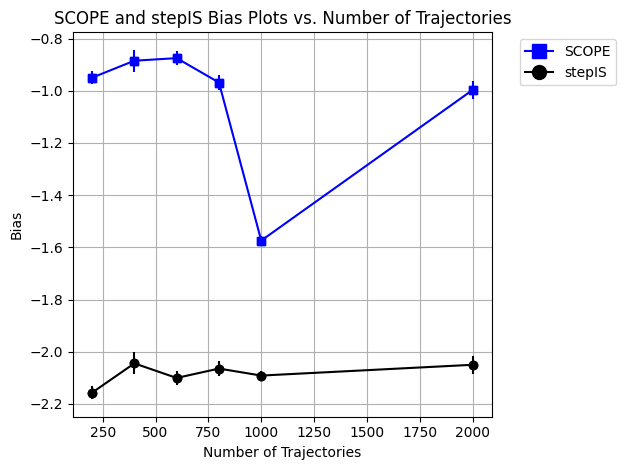

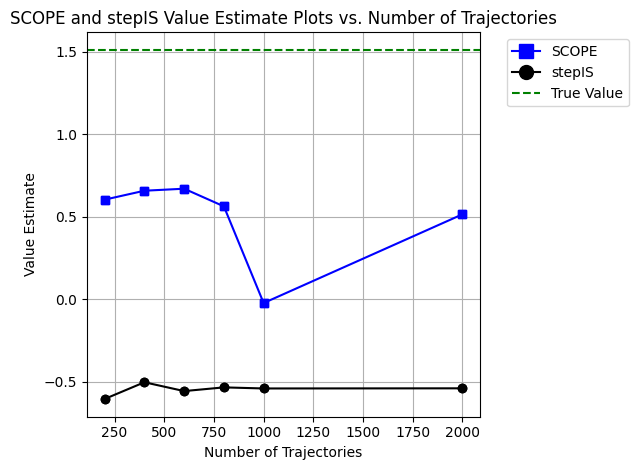

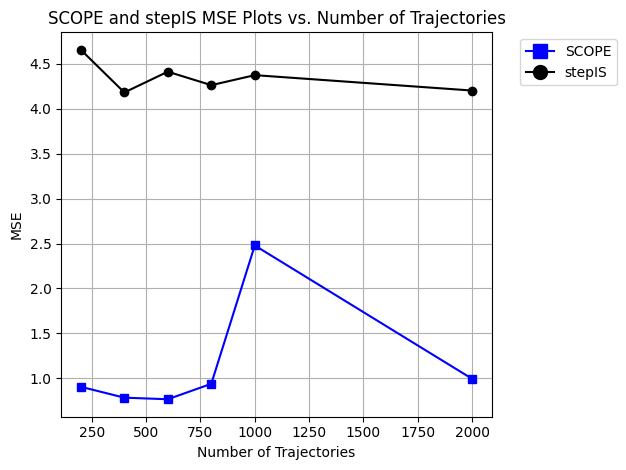

In [64]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((1, 2), 0), ((1, 3), 0), ((2, 2), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000,2000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [ 0.01310016 -0.11283875]
Variance Scope: 0.01010479095928979
----------
Iteration: 2
Beta: [ 0.00404821 -0.08844286]
Variance Scope: 0.00941122891736899
----------
Iteration: 3
Beta: [-0.0505089   0.05859455]
Variance Scope: 0.007481242384136196
----------
Var SCOPE_phi:  0.0073280648276731
Var IS_phi:  0.007620224497349726
Percent change in variance:  -3.834003444101123
SCOPE results:  {'std_devs_list': [0.047882013801273784, 0.04752601050024015, 0.047173060698265074, 0.047912298009566916, 0.049761161720299485], 'mean_list': [-0.06517289187898646, -0.06434514113626053, -0.06512079249039492, -0.06472618640438156, -0.06397840058015108]}
IS results:  {'std_devs_list': [0.04943129338382501, 0.04922782865471067, 0.049287743766277085, 0.04998573185893365, 0.052095697959821455], 'mean_list': [-0.49159533657178633, -0.4905843686680674, -0.4924379895411904, -0.491118153642736, -0.4907074756786435]}
true eval:  1.642240005427412
Loading  400  tra

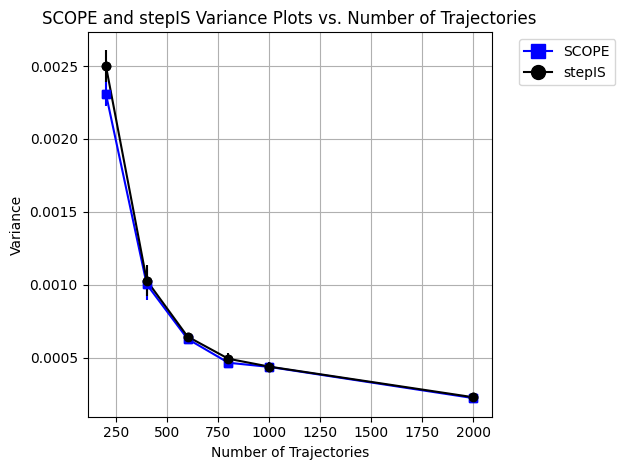

<Figure size 640x480 with 0 Axes>

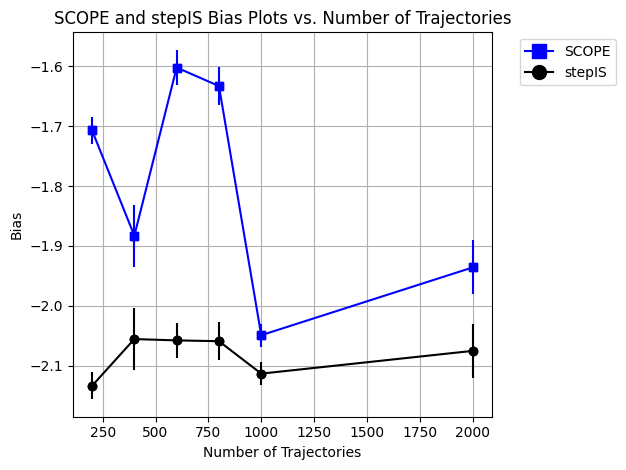

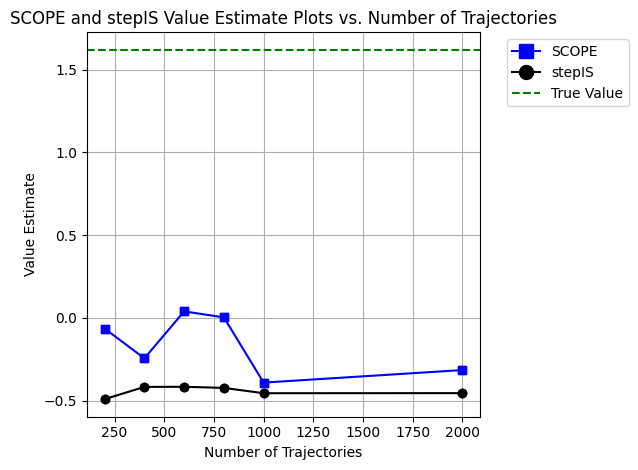

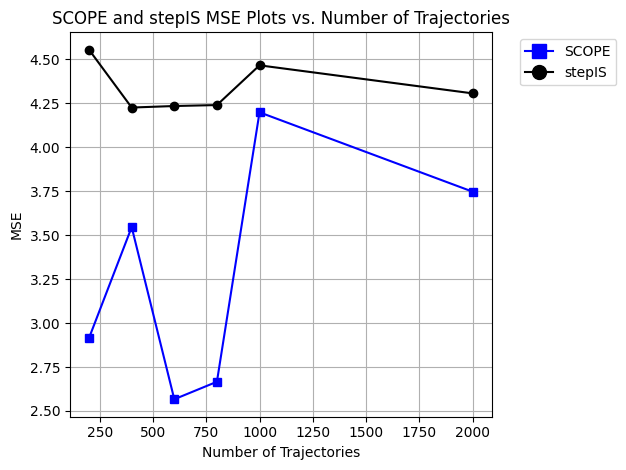

In [47]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((1, 2), -1), ((1, 3), 0), ((2, 2), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000,2000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [ 0.05245455 -0.12244836]
Variance Scope: 0.0033668055418176815
----------
Iteration: 2
Beta: [ 0.04130471 -0.10080714]
Variance Scope: 0.00267014440504771
----------
Iteration: 3
Beta: [-0.0261192   0.03005893]
Variance Scope: 0.0007246281177553213
----------
Var SCOPE_phi:  0.0008590930684358683
Var IS_phi:  0.001147451259903176
Percent change in variance:  -25.13032156953141
SCOPE results:  {'std_devs_list': [0.02354121452019542, 0.02388115825132504, 0.024553253953160693, 0.02369734837287237, 0.022634972345976705], 'mean_list': [0.01284758541195458, 0.011336875573222807, 0.012456168458517844, 0.011871323519678794, 0.01536858595023302]}
IS results:  {'std_devs_list': [0.022490146086715852, 0.023326481302000296, 0.023946206914884385, 0.02287249413158871, 0.022144226031487586], 'mean_list': [-0.1874240573201002, -0.18884047921992994, -0.1882273536796555, -0.18835952725282498, -0.18506389046517988]}
true eval:  1.9146637439106429
Loading  

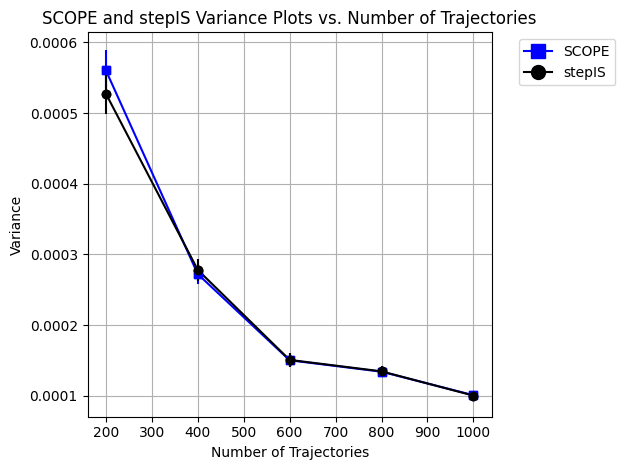

<Figure size 640x480 with 0 Axes>

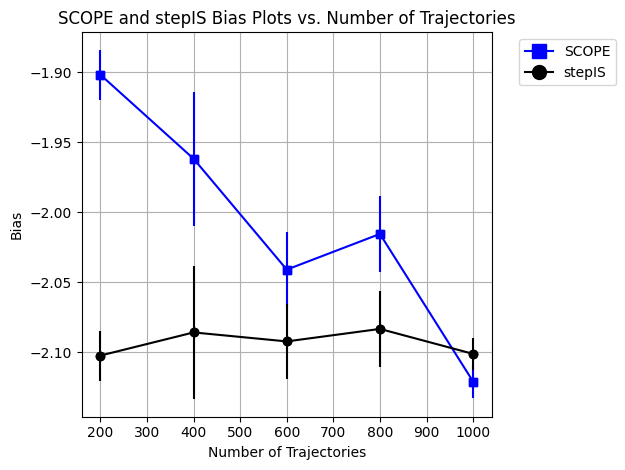

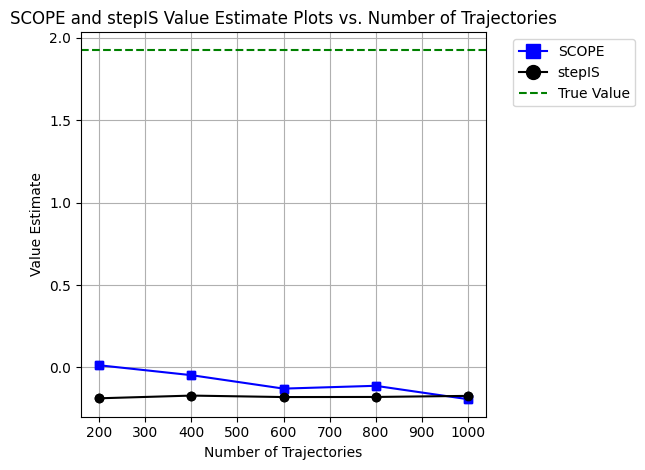

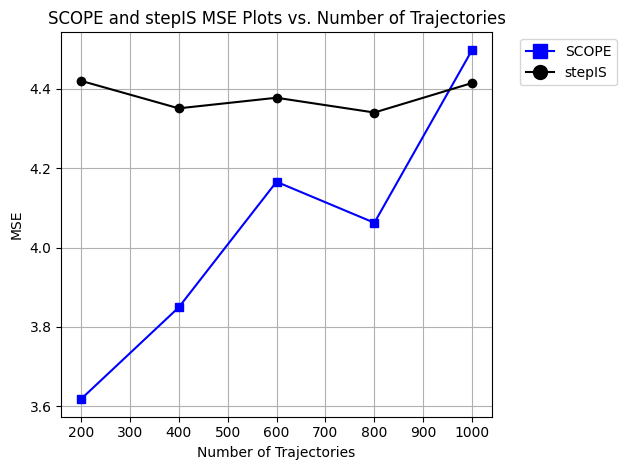

In [65]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((1, 3), -1), ((1, 4), -0.1), ((1, 2), -0.1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.03690995  0.05398219]
Variance Scope: 0.0006729036585540029
----------
Iteration: 2
Beta: [-0.03438466  0.04927396]
Variance Scope: 0.0006391739249006706
----------
Iteration: 3
Beta: [-0.01901587  0.02061996]
Variance Scope: 0.0005443275569088601
----------
Var SCOPE_phi:  0.0006625142510981093
Var IS_phi:  0.0008517362399311501
Percent change in variance:  -22.216031203314362
SCOPE results:  {'std_devs_list': [0.021400456557815313, 0.021763004463346575, 0.022403513312983295, 0.021558377967580433, 0.020946655600286676], 'mean_list': [0.020444006675448507, 0.018916719299714366, 0.019908178751119394, 0.01937346410564667, 0.022741041379170948]}
IS results:  {'std_devs_list': [0.02046326276043428, 0.021211849022097516, 0.021805477848415352, 0.02076484533085394, 0.02038825993556233], 'mean_list': [-0.13477729711369488, -0.13623469518924605, -0.13561402138488673, -0.1358191756841951, -0.13258882971589867]}
true eval:  1.959575911638024
Loa

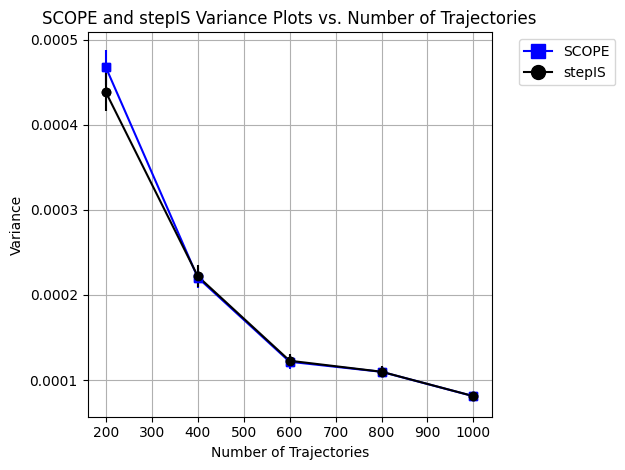

<Figure size 640x480 with 0 Axes>

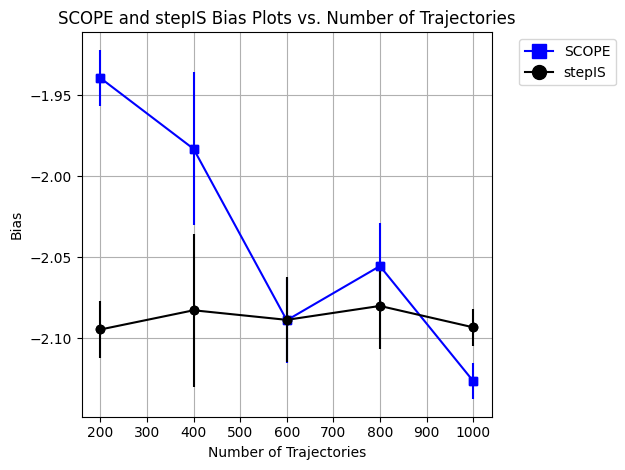

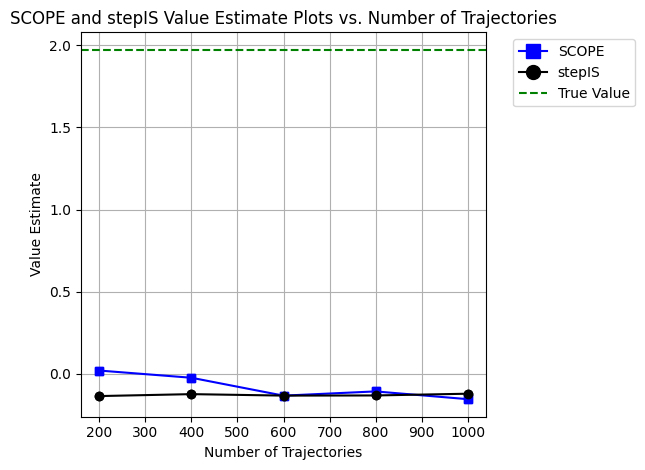

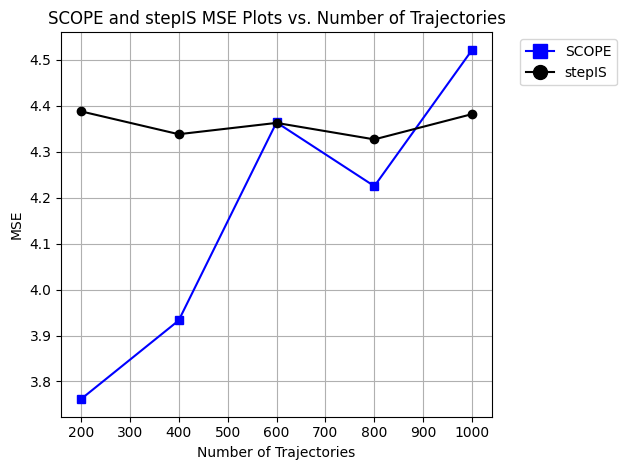

In [66]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((1, 3), -1), ((1, 4), 0), ((1, 2), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.24869013  0.34123245]
Variance Scope: 0.015717661906639827
----------
Iteration: 2
Beta: [-0.2207528   0.30354586]
Variance Scope: 0.012642990906173351
----------
Iteration: 3
Beta: [ 0.01058781 -0.00852526]
Variance Scope: 0.0006376698531174036
----------
Var SCOPE_phi:  0.0006568096809339188
Var IS_phi:  0.0007074116385575435
Percent change in variance:  -7.153113529034553
SCOPE results:  {'std_devs_list': [0.020003673195226085, 0.01885964101595238, 0.019681749906762396, 0.020081568954430546, 0.020469431653608868], 'mean_list': [-0.23270035307151027, -0.2322105099401323, -0.2327454304644812, -0.23116602505624662, -0.23262398991097233]}
IS results:  {'std_devs_list': [0.019797918542874274, 0.018623620692317187, 0.019556254805109707, 0.020012730152245976, 0.020408032973100204], 'mean_list': [-0.12434507685666901, -0.12386647012849362, -0.12424345033732136, -0.12280215421306212, -0.12425960266776284]}
true eval:  1.917160400585016
Load

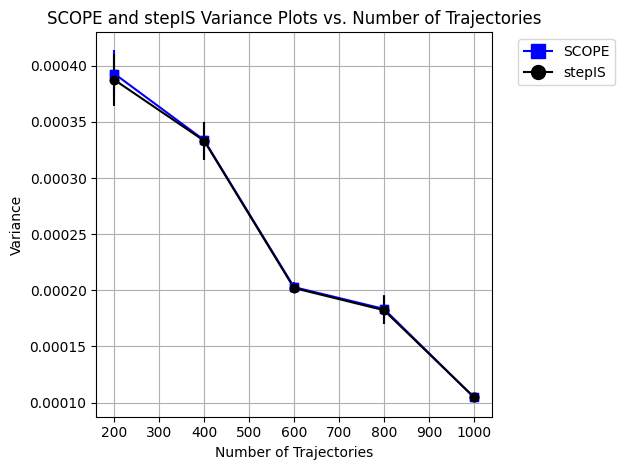

<Figure size 640x480 with 0 Axes>

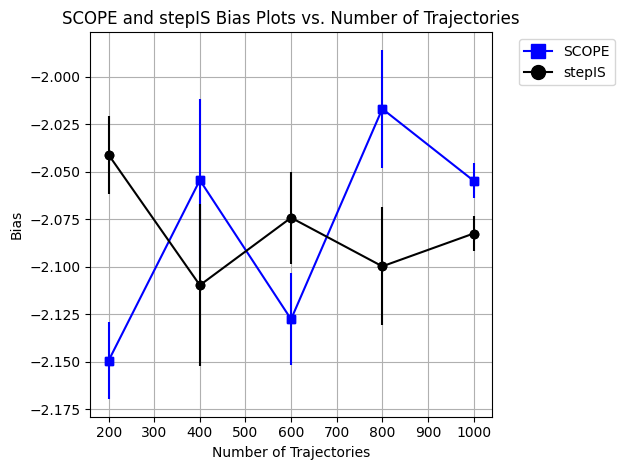

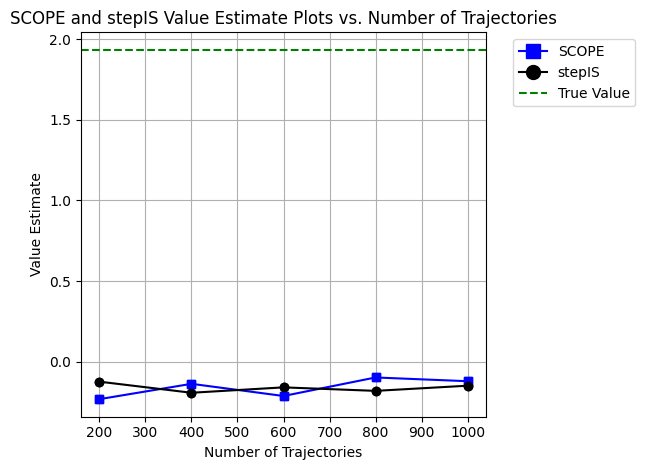

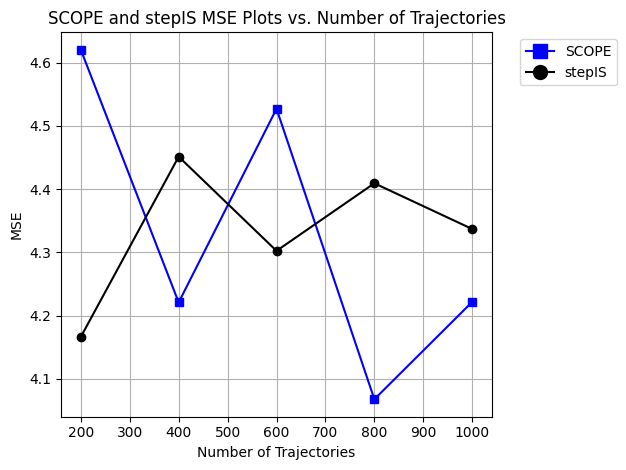

In [67]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((3, 1), -1), ((4, 1), 0), ((2, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.11767326  0.16274795]
Variance Scope: 0.003367247743678423
----------
Iteration: 2
Beta: [-0.06617997  0.0940967 ]
Variance Scope: 0.001627993753769254
----------
Iteration: 3
Beta: [ 0.0118228  -0.00989734]
Variance Scope: 0.0006375783868271876
----------
Var SCOPE_phi:  0.0006583718567771401
Var IS_phi:  0.0007074116385575435
Percent change in variance:  -6.932283709722189
SCOPE results:  {'std_devs_list': [0.019979329300750415, 0.018837970803647103, 0.019648069581046784, 0.020050646703422374, 0.02044911328457522], 'mean_list': [-0.22072209790699782, -0.22024032621533113, -0.2207642616729589, -0.21918649762264472, -0.22063708515961805]}
IS results:  {'std_devs_list': [0.019797918542874274, 0.018623620692317187, 0.019556254805109707, 0.020012730152245976, 0.020408032973100204], 'mean_list': [-0.12434507685666901, -0.12386647012849362, -0.12424345033732136, -0.12280215421306212, -0.12425960266776284]}
true eval:  1.917160400585016
Loa

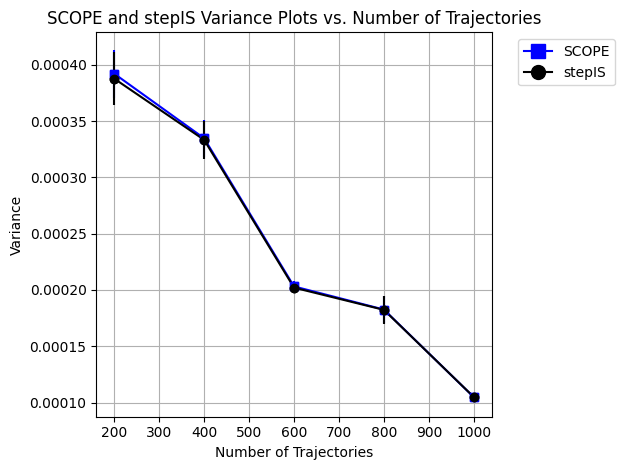

<Figure size 640x480 with 0 Axes>

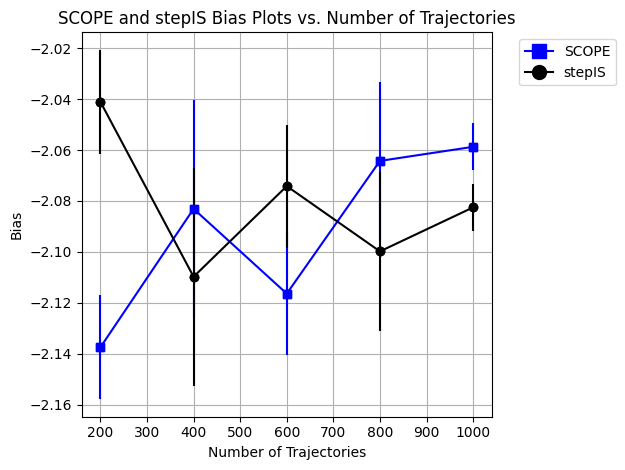

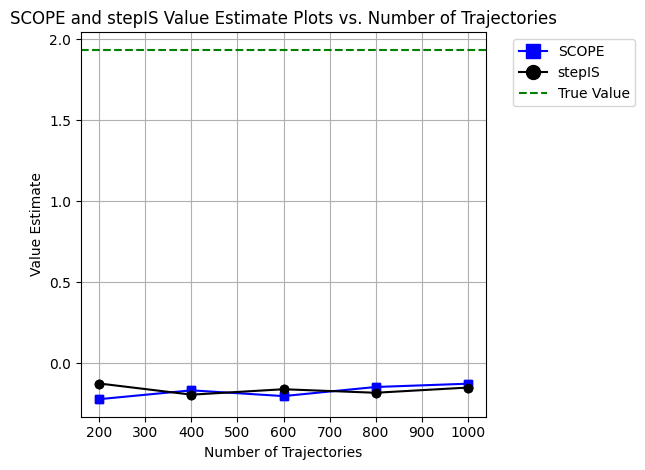

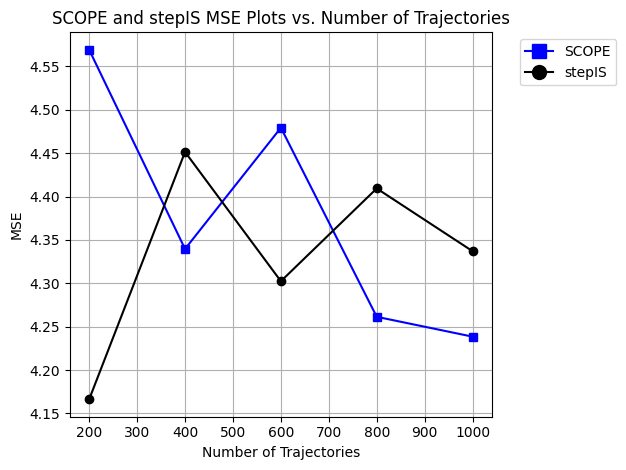

In [42]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((3, 1), -1), ((4, 1), 0), ((3, 2), 0),((4,2),0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,40  0, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.16524973  0.24909266]
Variance Scope: 0.009506430527645666
----------
Iteration: 2
Beta: [-0.13808083  0.20830084]
Variance Scope: 0.007456742589325766
----------
Iteration: 3
Beta: [-0.01957883  0.03038011]
Variance Scope: 0.003446425689584341
----------
Var SCOPE_phi:  0.004427951104616638
Var IS_phi:  0.004393223011992214
Percent change in variance:  0.790492368123032
SCOPE results:  {'std_devs_list': [0.05243158146984321, 0.055492171924954356, 0.04917138711753906, 0.04911576149467292, 0.04915280449870791], 'mean_list': [-0.24536591274616332, -0.24373396671221423, -0.24487937162704826, -0.24263486639523094, -0.2453032005115002]}
IS results:  {'std_devs_list': [0.052749117648068895, 0.05578868561579654, 0.049526228145490556, 0.049391881753162586, 0.04934041677432741], 'mean_list': [-0.2646910526840784, -0.2632094933438104, -0.2641977175805876, -0.2618945726864196, -0.2646488384161943]}
true eval:  1.8535453937642141
Loading  400  tr

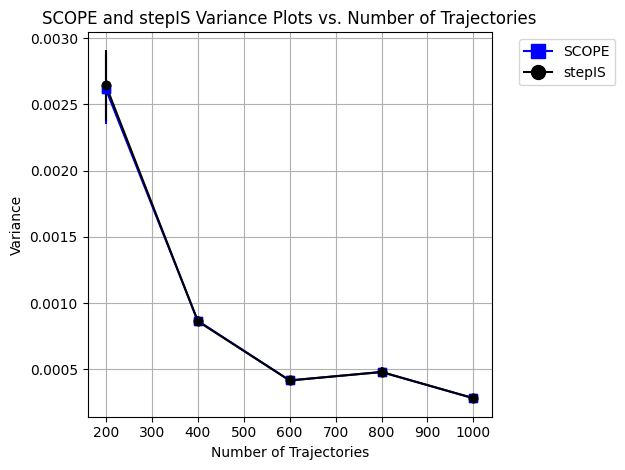

<Figure size 640x480 with 0 Axes>

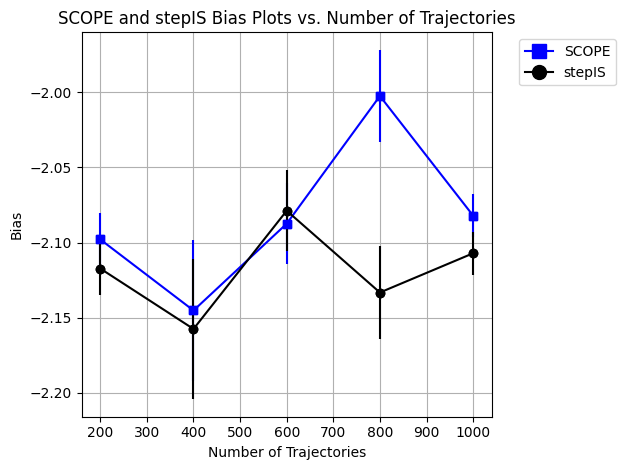

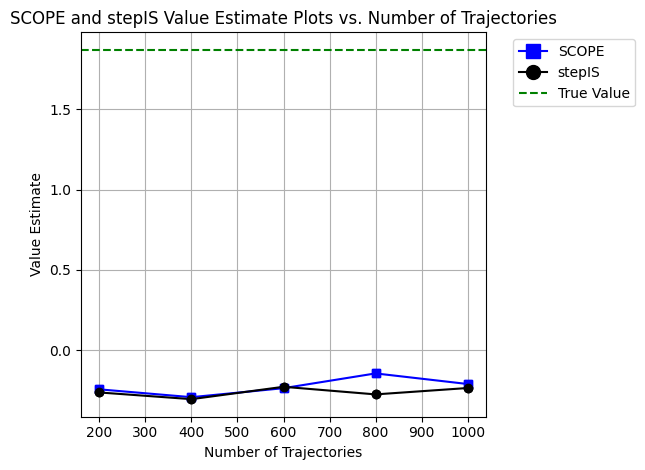

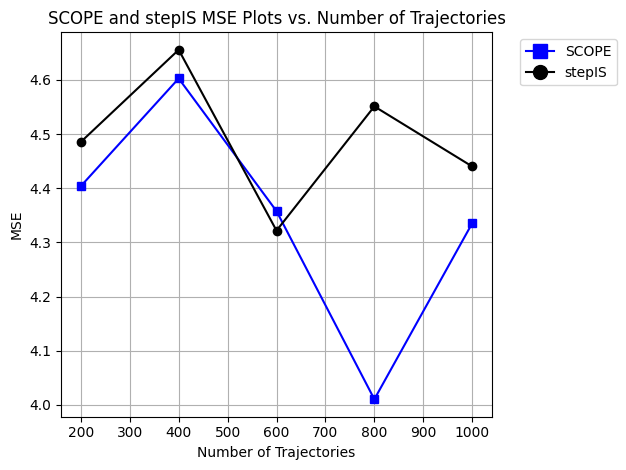

In [44]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((3, 1), -1), ((4, 1), -1), ((3, 2), 0),((4,2),0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

## Dense, 1 bad, similar

## Sparse, 1 bad, similar